<a id='top'></a>
# Running the spectroscopic pipeline: NIRSpec Fixed Slit

**Author**: James Muzerolle

Plotting function originally developed by Bryan Hilbert

**Latest Update**: 11 June 2021

## Table of Contents
* [Introduction](#intro)
    * [Overview](#overview)
    * [Simulated data](#sims)
* [Imports](#imports)
* [Convenience functions](#func)
* [Download the data](#data)
* [Input data](#inputs)
* [Level 2 association files](#lvl2asn)
* [Run the calwebb_spec2 pipeline](#runspec2)
* [Run individual steps of the spec2 pipeline](#runspec2steps)
    * [assign_wcs](#awcs)
    * [background](#background)
    * [extract_2d](#extract2d)
    * [sourcetype](#srctype)
    * [wavecorr](#wavecorr)
    * [flat_field](#flat)
    * [pathloss](#pathloss)
    * [photom](#photom)
    * [resample_spec](#resample)
    * [extract_1d](#extract1d)
* [Run the calwebb_spec3 pipeline](#runspec3)
    * [Rerun extract_1d with a different extraction aperture](#rerun)

## Introduction <a id='intro'></a>

### Overview <a id='overview'></a>

In this notebook, we will explore the stage 2 and 3 pipelines for spectroscopic data, using the NIRSpec Fixed Slit mode as an example.  Since the previous two notebooks described these pipelines and all their component steps for all spectroscopic modes, we will focus on the mechanics of processing "real" example data, including how to use associations for background subtraction and multi-exposure combination, what particular steps actually do to the data, and what the primary data products at each stage look like.  We will also briefly examine how to interact and work with data models for each product.

We are using pipeline version 1.1.0 for all data processing in this notebook. Most of the processing runs shown here use the default reference files from the Calibration Reference Data System (CRDS), with one exception at the end to show an example of how to modify/override. Please note that pipeline software development is a continuous process, so results in some cases may be slightly different if using a subsequent version.  There are also a few known issues with some of the pipeline steps in this build that are expected to be fixed in the near future, though these do not significantly effect the products you will see here.  Finally, some of the calibration reference files used by individual pipeline steps in the current CRDS context are placeholders, as they require calibrations that can only be taken in flight; for this reason, the absolute flux values seen here should not be taken literally.

### Simulated data <a id='sims'></a>

We will be using simulated NIRSpec exposures generated by the ESA Instrument Performance Simulator (IPS), using an input scene consisting of a point source with an A-star stellar model spectrum. The observation consists of 9 dithered exposures with the S200A1 slit, including a 3-point primary dither pattern with spectral subdithers. The instrument was configured with the PRISM+CLEAR grating/filter combination and a detector subarray of SUBS200A1 (2048x64 pixels on each detector). The dithers are numbered for convenience in these example file names according to the source position in the slit, as shown schematically below. These file names are not indicative of actual data product file names you will see in the archive.

1 2 3

4 5 6

7 8 9


There are a number of caveats to be aware of regarding these simulated data.  1) The IPS does not include a full treatment of all of the effects corrected by the stage 2 pipeline, particularly some of the throughput components. As with the above caveat regarding reference files, the simulations shown here should not be used for any analyses of flux information.  2) The simulated PSF is truncated in order to save on computation time.  In some cases, you may see an artifical drop in apparent count rate in the PSF wings.  3) Spacecraft pointing-related information has to be added by-hand to the headers before the simulated data can be processed by the pipeline.  These keywords are used by the stage 3 pipeline when combining exposures, in order to align the spectral traces.  Because this has to be a manual process and may be subject to small errors, the quality of the combined products here should not be taken as indicative of actual in-flight performance.

## Imports <a id='imports'></a>

Import packages necessary for this notebook

In [1]:
import numpy as np

import glob

import os
import zipfile
import urllib.request

import json

from astropy.io import fits
from astropy.utils.data import download_file
from astropy.visualization import ImageNormalize, ManualInterval, LogStretch, LinearStretch, AsinhStretch

Set up matplotlib for plotting

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# Use this version for non-interactive plots (easier scrolling of the notebook)
%matplotlib inline

# Use this version (outside of Jupyter Lab) if you want interactive plots
#%matplotlib notebook

# These gymnastics are needed to make the sizes of the figures
# be the same in both the inline and notebook versions
%config InlineBackend.print_figure_kwargs = {'bbox_inches': None}

mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80

Import JWST pipeline modules

In [3]:
# The calwebb_spec and spec3 pipelines
from jwst.pipeline import Spec2Pipeline
from jwst.pipeline import Spec3Pipeline

# individual steps
from jwst.assign_wcs import AssignWcsStep
from jwst.background import BackgroundStep
from jwst.imprint import ImprintStep
from jwst.msaflagopen import MSAFlagOpenStep
from jwst.extract_2d import Extract2dStep
from jwst.srctype import SourceTypeStep
from jwst.wavecorr import WavecorrStep
from jwst.flatfield import FlatFieldStep
from jwst.pathloss import PathLossStep
from jwst.photom import PhotomStep
from jwst.resample import ResampleSpecStep
from jwst.extract_1d import Extract1dStep

# data models
from jwst import datamodels

2021-06-15 12:37:52,403 - stpipe - WARNING - /Users/muzerol/anaconda3/envs/jwst_1.1/lib/python3.9/site-packages/photutils/detection/findstars.py:33: AstropyDeprecationWarning: _StarFinderKernel was moved to the photutils.detection._utils module. Please update your import statement.
  warnings.warn(f'{name} was moved to the {deprecated[name]} module. '



<p style="font-size:200%; color:#e56020; background-color:#1d1160;"><b><i>Reviewer note:</i> Begin PEP8 check cells (delete below when finished)</b></p>

In [4]:
# disable all imported packages' loggers
import logging
logging.root.manager.loggerDict = {}

In [7]:
# enable PEP8 checker for this notebook
%load_ext pycodestyle_magic
%flake8_on --ignore E261,E501,W291,W293

# only allow the checker to throw warnings when there's a violation
logging.getLogger('flake8').setLevel('ERROR')
logging.getLogger('pycodestyle').setLevel('ERROR')

2021-06-15 12:43:06,401 - stpipe - INFO - 1: E999 SyntaxError: invalid syntax
2021-06-15 12:43:06,401 - stpipe - INFO - 3:13: E225 missing whitespace around operator
2021-06-15 12:43:06,401 - stpipe - INFO - 3:25: E231 missing whitespace after ','
2021-06-15 12:43:06,402 - stpipe - INFO - 3:30: E231 missing whitespace after ','
2021-06-15 12:43:06,402 - stpipe - INFO - 3:35: E231 missing whitespace after ','


The pycodestyle_magic extension is already loaded. To reload it, use:
  %reload_ext pycodestyle_magic


<p style="font-size:200%; color:#e56020; background-color:#1d1160;"><b><i>Reviewer note:</i> End PEP8 check cells (delete above when finished)</b></p>

## Define convenience functions and parameters <a id='func'></a>

In [64]:
# All files created in this notebook will be saved to the current working directory
# create a subdirectory to organize the files
output_dir = './nirspec_files/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

2021-06-21 13:40:31,204 - stpipe - WARNING - /Users/muzerol/anaconda3/envs/jwst_1.1/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



In [9]:
def show_image(data_2d, vmin, vmax, title=None, aspect=1, scale='log', units='MJy/sr'):
    """Function to generate a 2D, log-scaled image of the data
    
    Parameters
    ----------
    data_2d : numpy.ndarray
        2D image to be displayed
        
    vmin : float
        Minimum signal value to use for scaling
        
    vmax : float
        Maximum signal value to use for scaling
        
    title : str
        String to use for the plot title
        
    scale : str
        Specify scaling of the image. Can be 'log' or 'linear'
        
    units : str
        Units of the data. Used for the annotation in the
        color bar
    """
    if scale == 'log':
        norm = ImageNormalize(data_2d, interval=ManualInterval(vmin=vmin, vmax=vmax),
                              stretch=LogStretch())
    elif scale == 'linear':
        norm = ImageNormalize(data_2d, interval=ManualInterval(vmin=vmin, vmax=vmax),
                              stretch=LinearStretch())
    elif scale == 'Asinh':
        norm = ImageNormalize(data_2d, interval=ManualInterval(vmin=vmin, vmax=vmax),
                              stretch=AsinhStretch())
    fig = plt.figure(figsize=(15, 9))
    ax = fig.add_subplot(1, 1, 1)
    im = ax.imshow(data_2d, origin='lower', norm=norm, aspect=aspect, cmap='gist_earth')

    fig.colorbar(im, label=units)
    plt.xlabel('Pixel column')
    plt.ylabel('Pixel row')
    if title:
        plt.title(title)

## Download the data <a id='data'></a>

First, let's grab the data from Box.

In [65]:
# set the Box link and file name
ziplink = 'https://stsci.box.com/shared/static/qdj79y7rv99wuui2hot0l3kg5ohq0ah9.zip'
zipfilename = 'nirspec_data.zip'
if not os.path.isfile(os.path.join(output_dir, zipfilename)):
    print('Downloading {}...'.format(zipfilename))
    demo_file = download_file(ziplink, cache=True)
    # Make a symbolic link using a local name for convenience
    os.symlink(demo_file, os.path.join(output_dir, zipfilename))
else:
    print('{} already exists, skipping download...'.format(zipfilename))

nirspec_data.zip already exists, skipping download...


In [12]:
# unzip
zf = zipfile.ZipFile(output_dir+'nirspec_data.zip', 'r')
zf.extractall(output_dir)

## Input data <a id='inputs'></a>

Because the simulator generates count rate maps, equivalent to level 2a data products, we have to skip stage 1 of the pipeline and instead start the processing with the calwebb_spec2 pipeline.

First, let's take a look at a few of the level 2a images to get familiarized with the inputs.

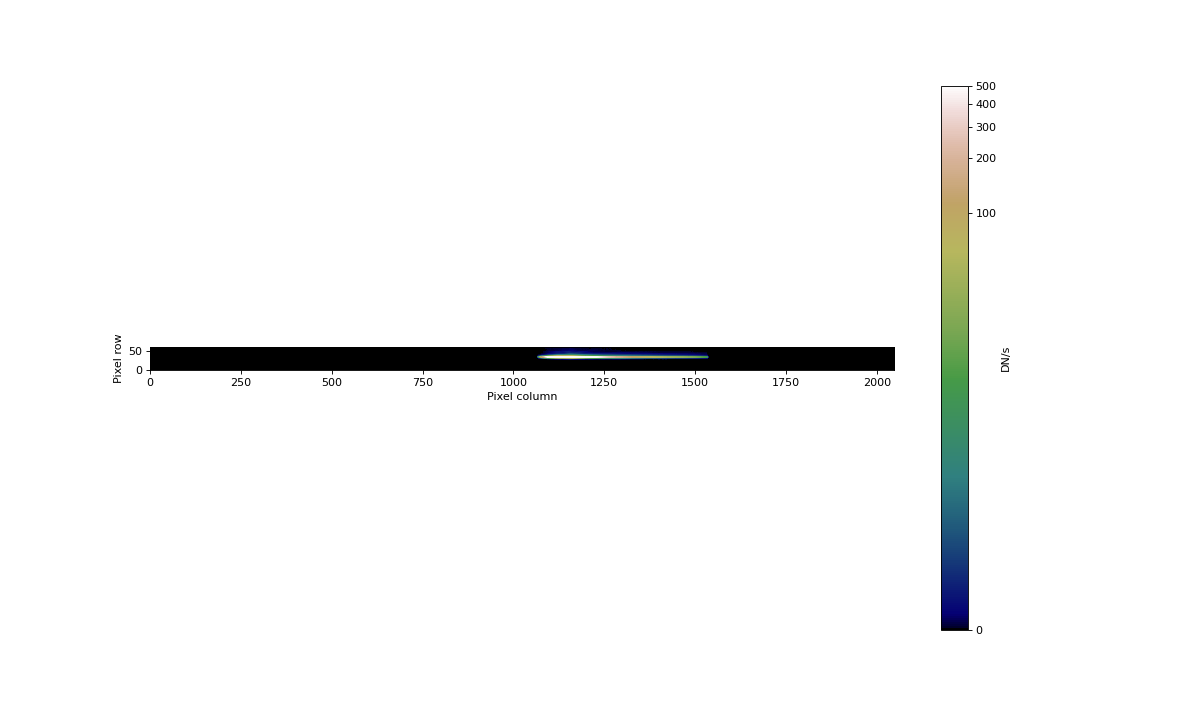

In [14]:
# get the data model of dither position 1:
ratefile = output_dir+'nirspec_fssim_d1_rate.fits'
dither = datamodels.open(ratefile)

# get the pixel data (the SCI extension of the fits file)
ratesci = dither.data

# display the image
show_image(ratesci, 0, 5.e2, units='DN/s')

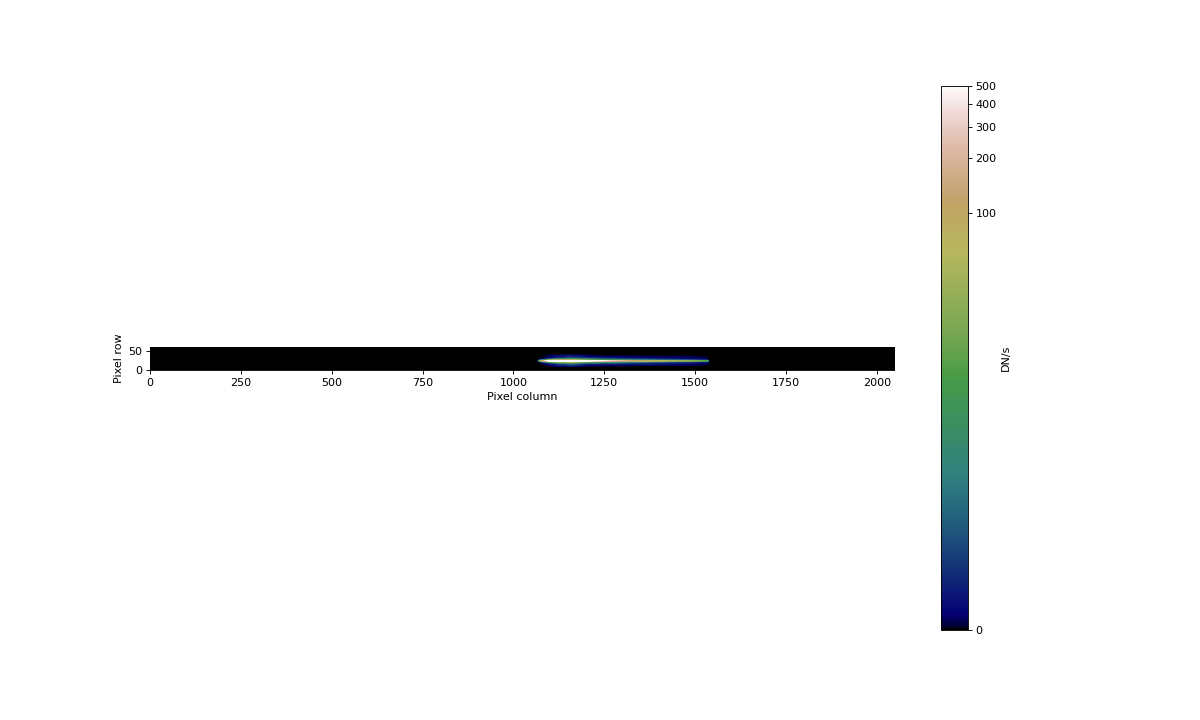

In [15]:
# get the data model of dither position 4:
ratefile = output_dir+'nirspec_fssim_d4_rate.fits'
dither = datamodels.open(ratefile)

# get the pixel data (the SCI extension of the fits file)
ratesci = dither.data

# display the image
show_image(ratesci, 0, 5.e2, units='DN/s')

Note how the source spectral trace moves "down" in the y (spatial) direction.  Because the disperser used here is the PRISM, the length of the trace is much shorter than the ALLSLITS subarray width.

## Level 2 association files <a id='lvl2asn'></a>

One purpose of the primary dither pattern in this case is to enable background subtraction.  The spec2 pipeline is set up to handle this by using association files that list the exposures to be used as backgrounds for each input exposure.  The background elements can also be specified manually as inputs into the "background" step, but we'll be using association files in this example.

In [16]:
# get the association files
asnlist = [f for f in glob.glob(output_dir+"spec2*json")]
asnlist.sort()
print(asnlist)

['./nirspec_files/spec2_001_asn.json', './nirspec_files/spec2_002_asn.json', './nirspec_files/spec2_003_asn.json', './nirspec_files/spec2_004_asn.json', './nirspec_files/spec2_005_asn.json', './nirspec_files/spec2_006_asn.json', './nirspec_files/spec2_007_asn.json', './nirspec_files/spec2_008_asn.json', './nirspec_files/spec2_009_asn.json']


In [17]:
# show the contents of one of the association files
asn_file = asnlist[0]
with open(asn_file) as f_obj:
    asn_data = json.load(f_obj)
asn_data

{'asn_type': 'spec2',
 'asn_rule': 'candidate_Asn_Lv2NRSFSS',
 'version_id': '20210311t152305',
 'code_version': '1.1.0',
 'degraded_status': 'No known degraded exposures in association.',
 'program': '00675',
 'constraints': 'DMSAttrConstraint({\'name\': \'program\', \'sources\': [\'program\'], \'value\': \'675\'})\nDMSAttrConstraint({\'name\': \'is_tso\', \'sources\': [\'tsovisit\'], \'value\': None})\nDMSAttrConstraint({\'name\': \'instrument\', \'sources\': [\'instrume\'], \'value\': \'nirspec\'})\nDMSAttrConstraint({\'name\': \'detector\', \'sources\': [\'detector\'], \'value\': \'nrs1\'})\nDMSAttrConstraint({\'name\': \'opt_elem\', \'sources\': [\'filter\'], \'value\': \'clear\'})\nDMSAttrConstraint({\'name\': \'opt_elem2\', \'sources\': [\'grating\'], \'value\': \'prism\'})\nDMSAttrConstraint({\'name\': \'opt_elem3\', \'sources\': [\'fxd_slit\'], \'value\': \'s200a1\'})\nDMSAttrConstraint({\'name\': \'subarray\', \'sources\': [\'subarray\'], \'value\': \'subs200a1\'})\nDMSAttrCo

## Run the calwebb_spec2 pipeline <a id='runspec2'></a>

The following cell demonstrates how to run the calwebb_spec2 pipeline in full, using the above association files as inputs.  Since this takes a bit too long to run in real time during the webinar, the cell has been disabled.  In order to run it offline, simply delete or comment out the top line. 

In [18]:
%%script false --no-raise-error

# loop over the association files (one per exposure)
for asn in asnlist:
    spec2 = Spec2Pipeline()
    spec2.save_results = True
    spec2.output_dir = output_dir
    # skip the flat field correction, since the simulations do not include a full treatment of the throughput
    spec2.flat_field.skip = True
    result = spec2(asn)

./nirspec_files/nirspec_fssim_d1_cal.fits
S200A1


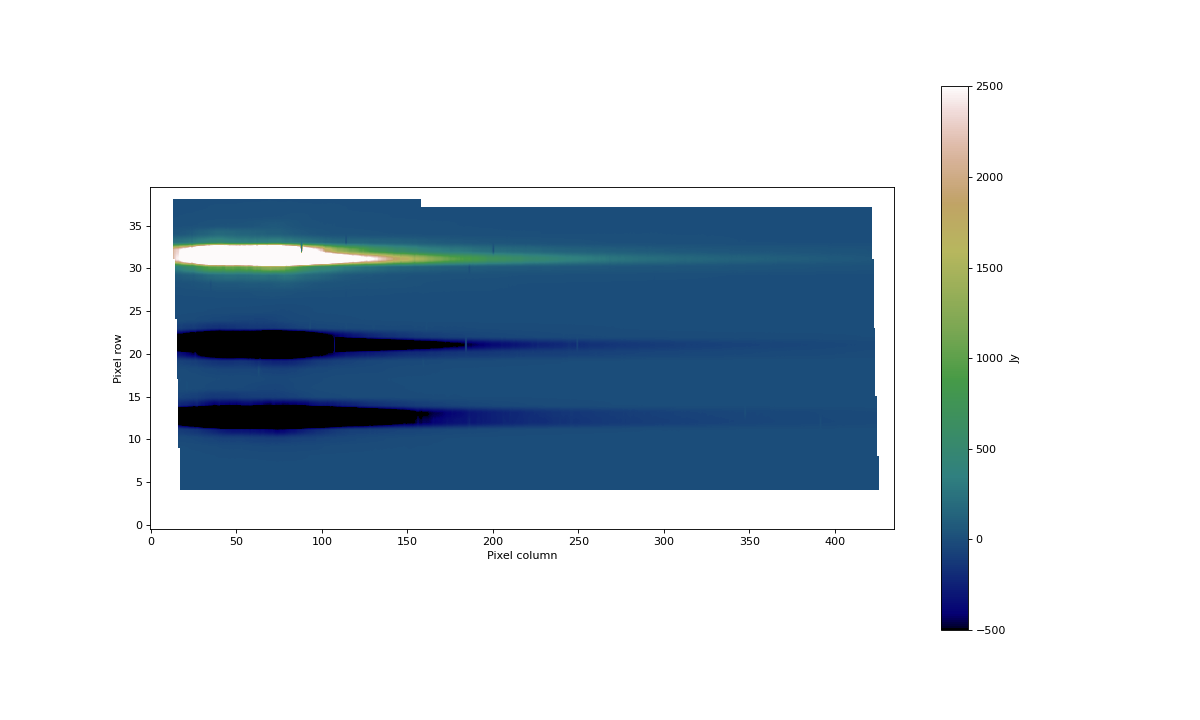

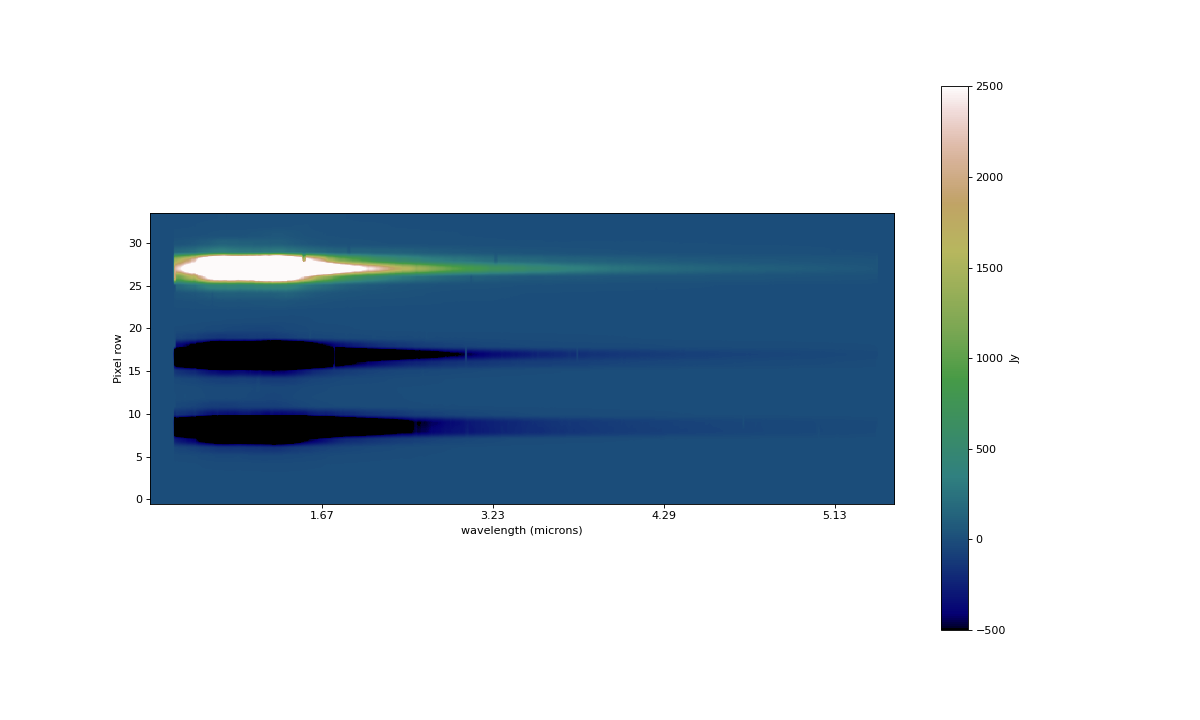

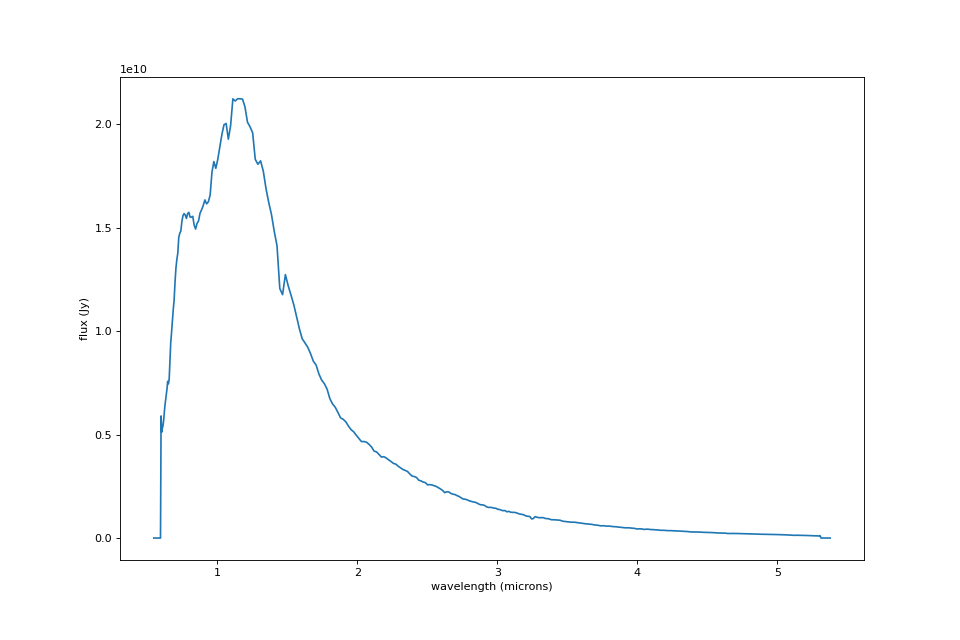

./nirspec_files/nirspec_fssim_d2_cal.fits
S200A1


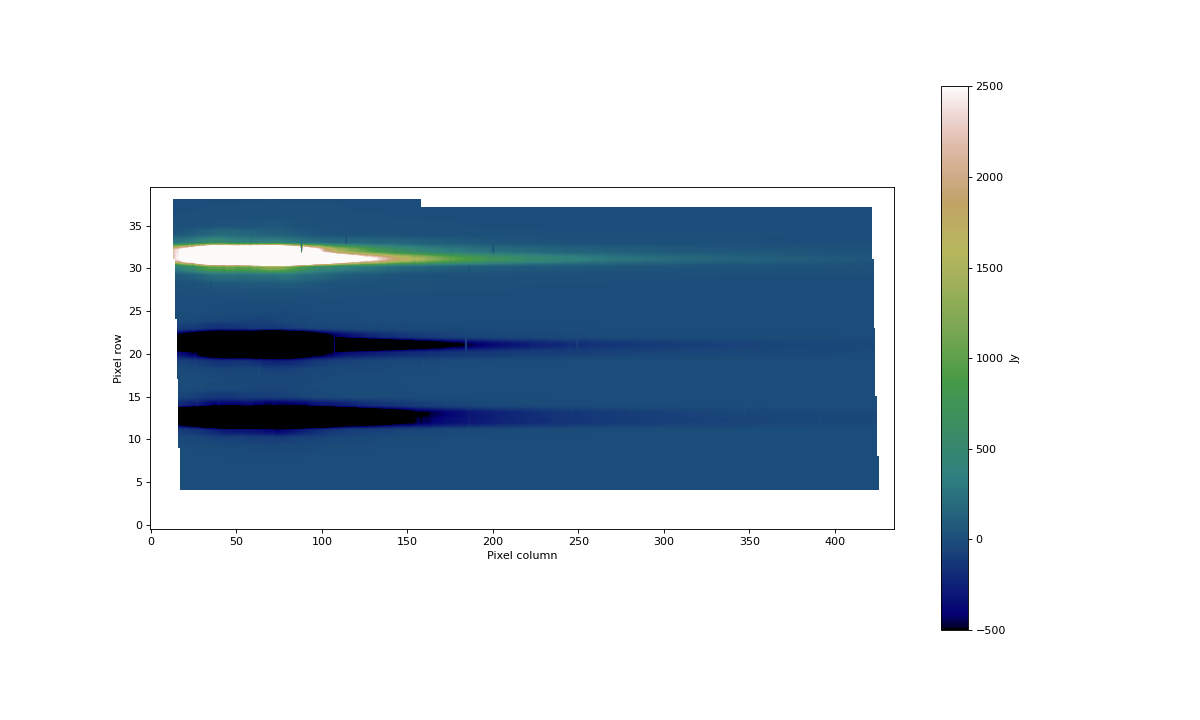

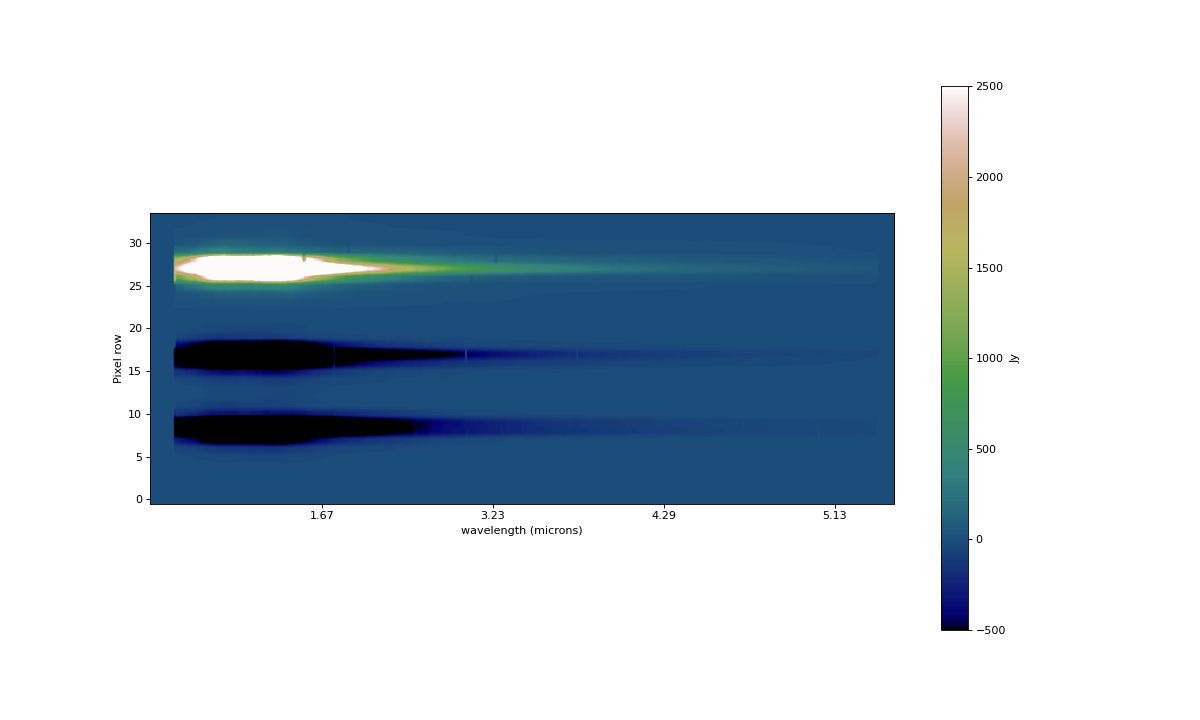

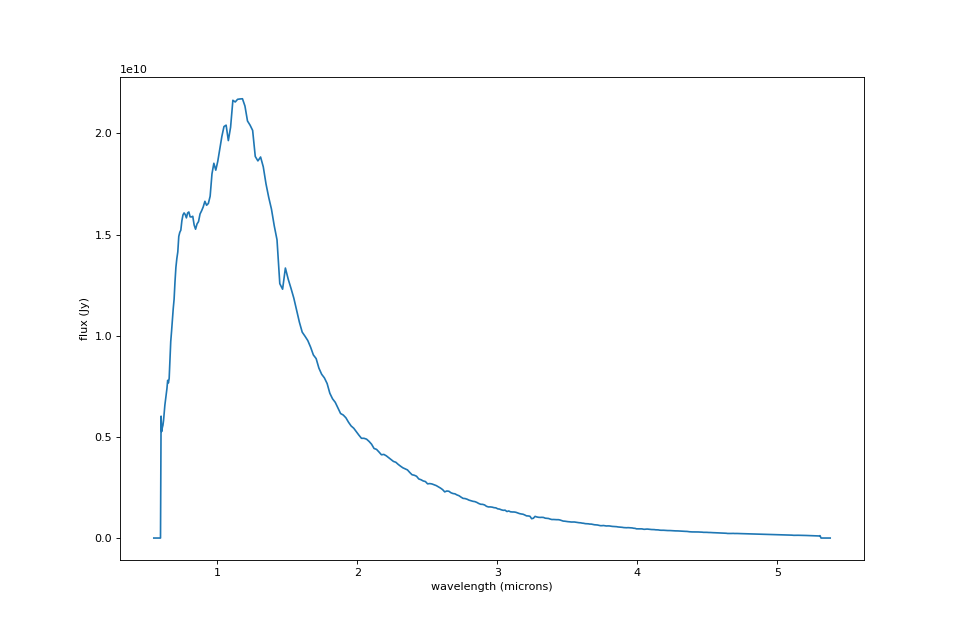

./nirspec_files/nirspec_fssim_d3_cal.fits
S200A1


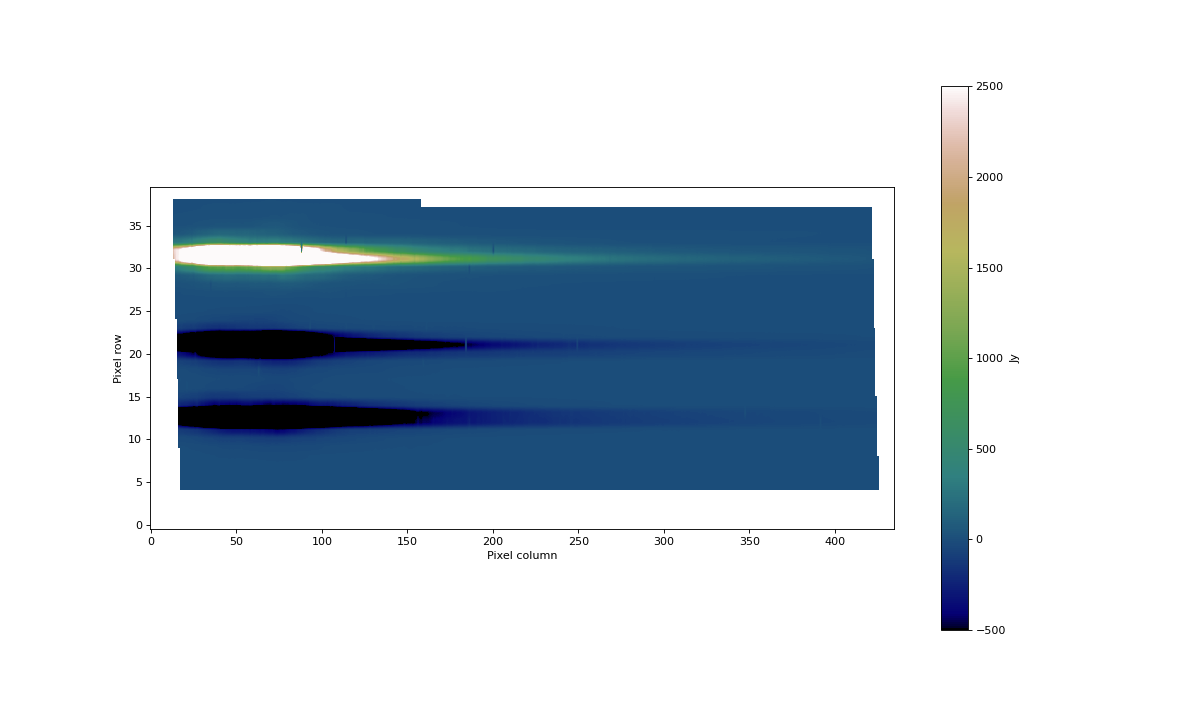

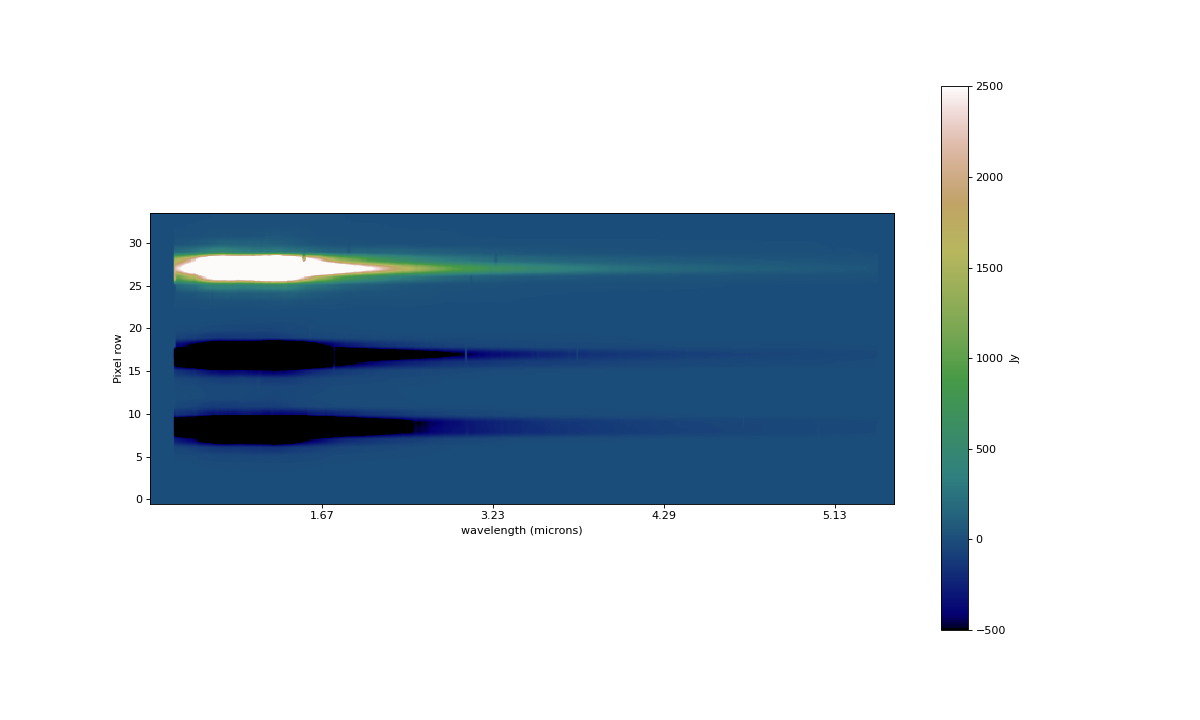

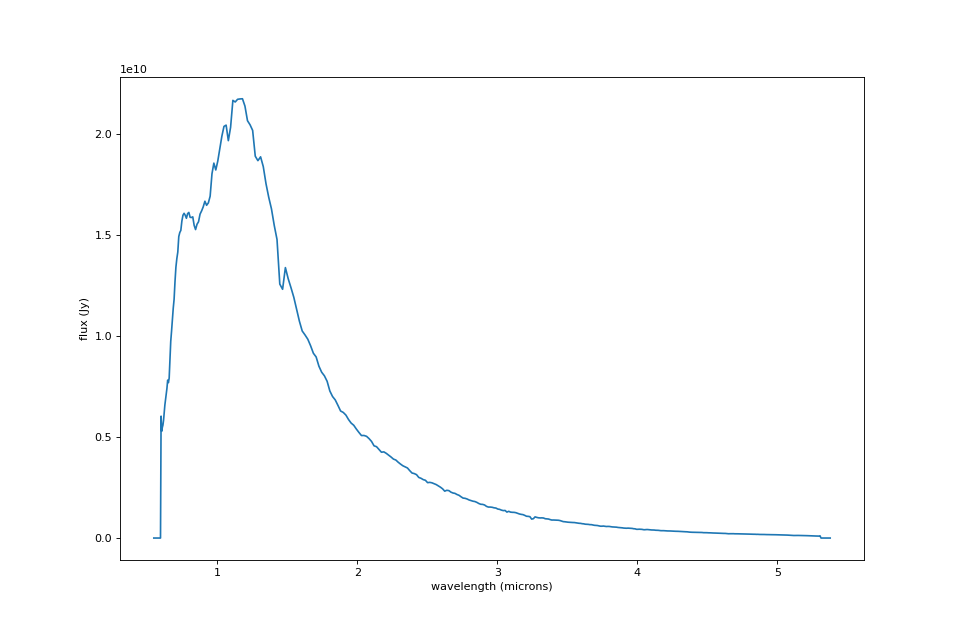

./nirspec_files/nirspec_fssim_d4_cal.fits
S200A1


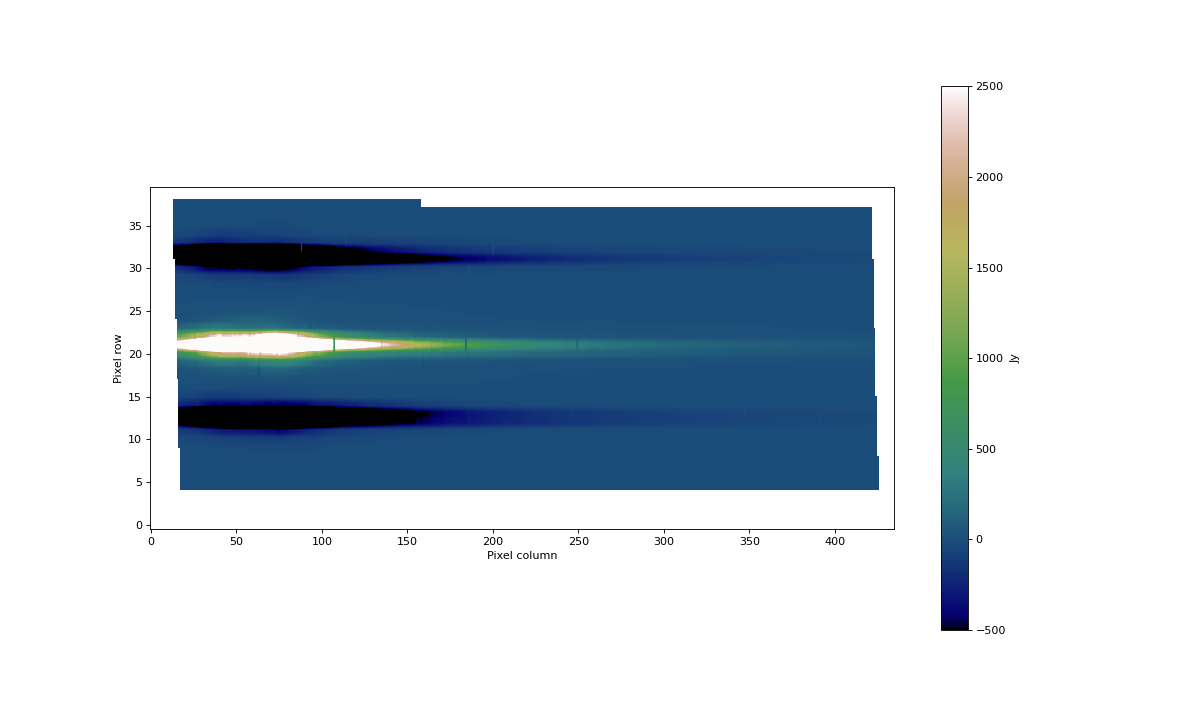

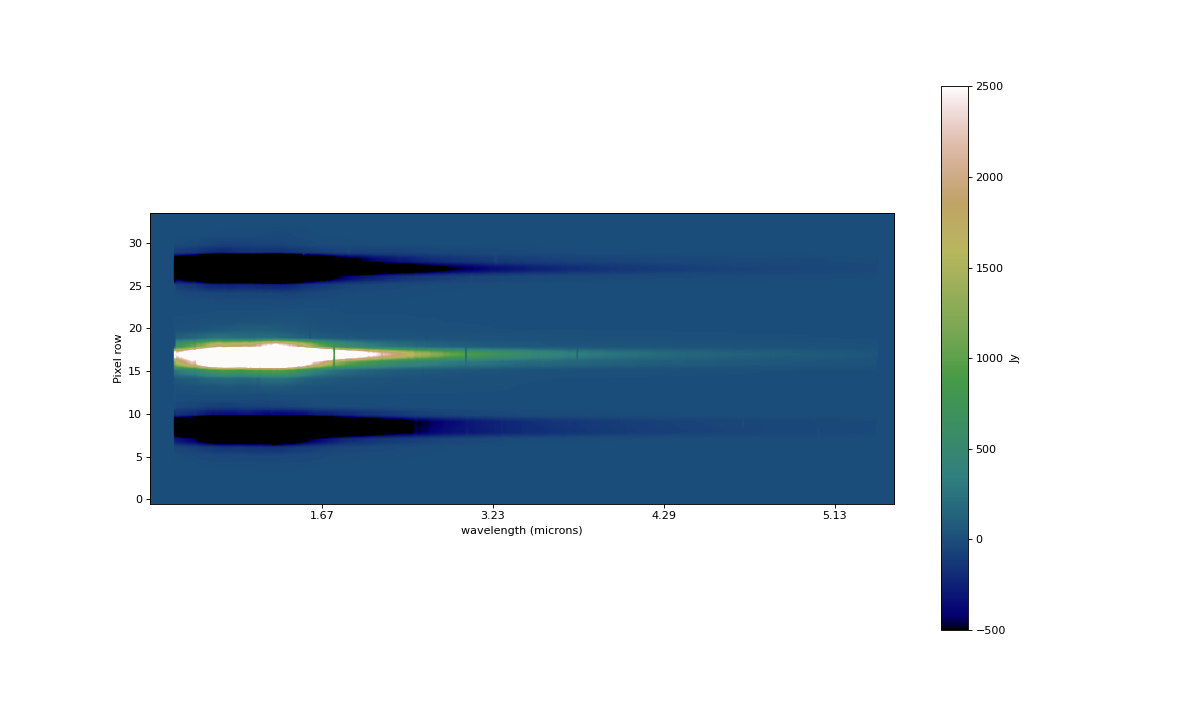

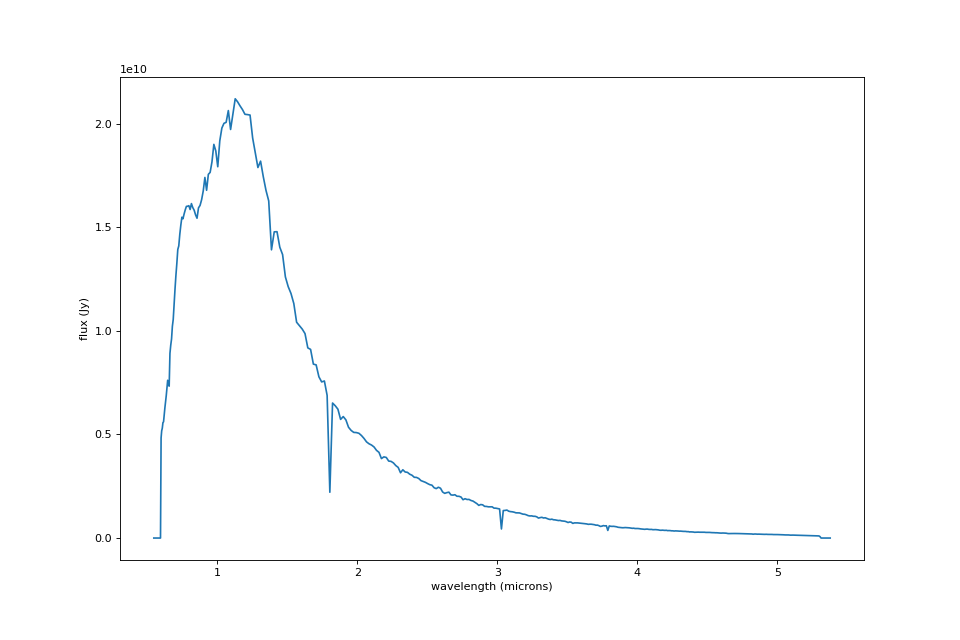

./nirspec_files/nirspec_fssim_d5_cal.fits
S200A1


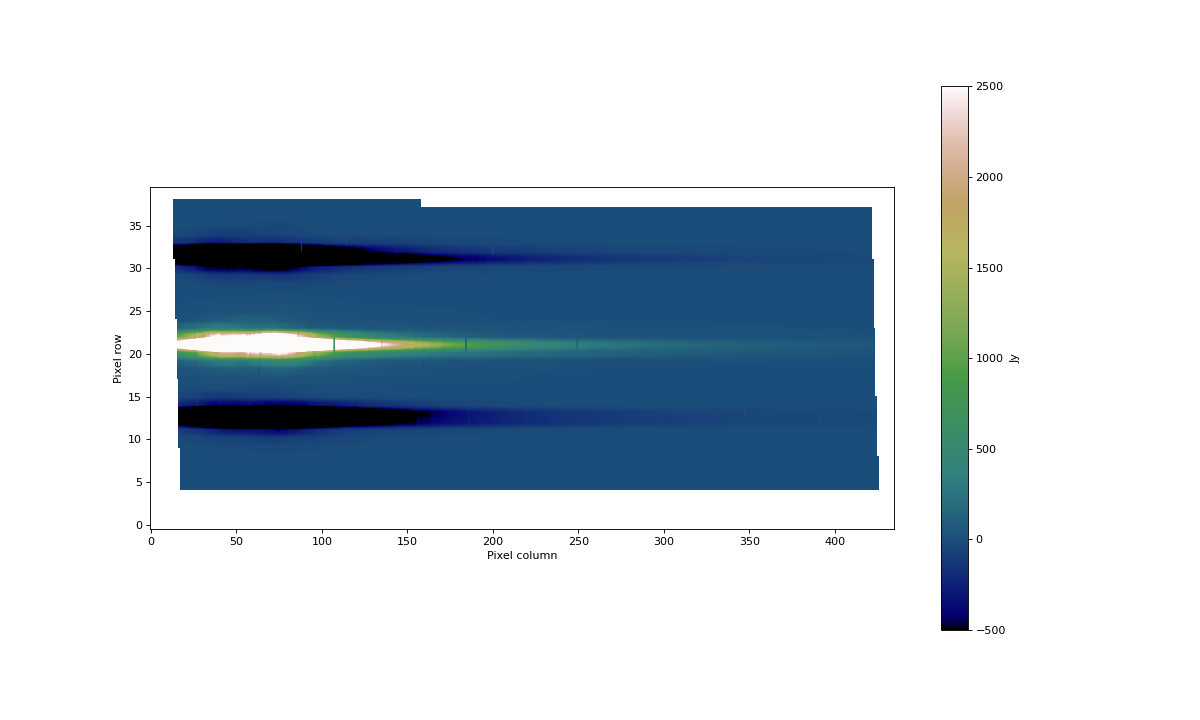

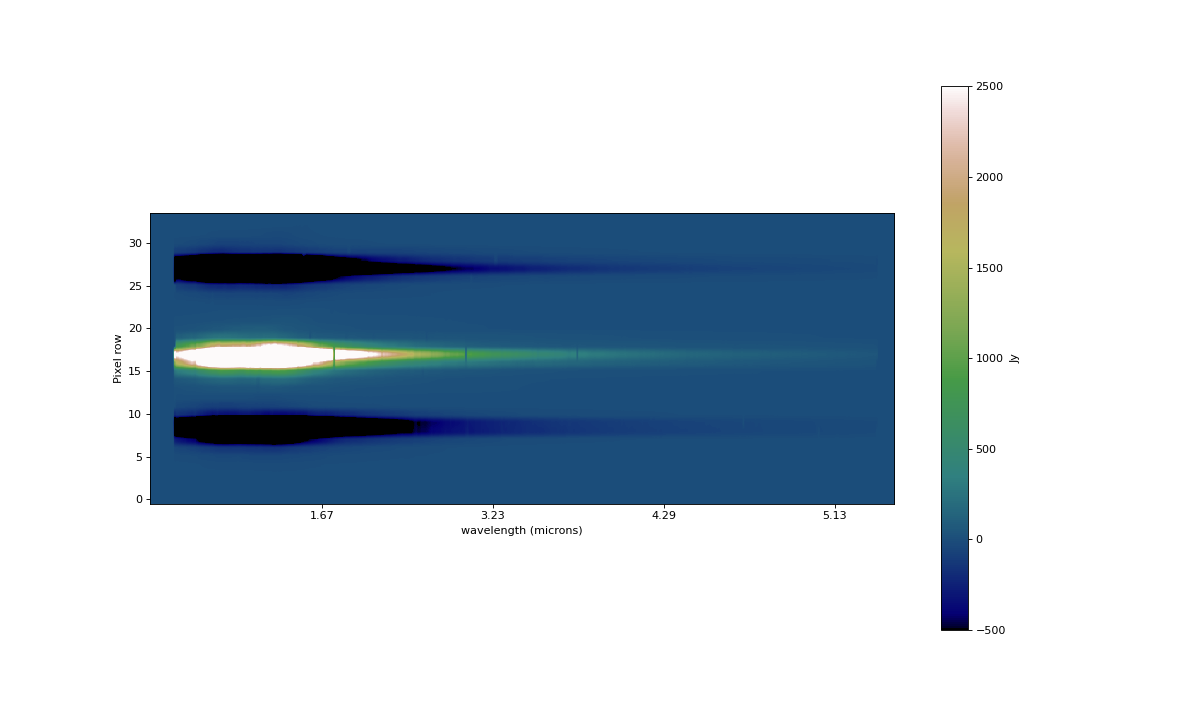

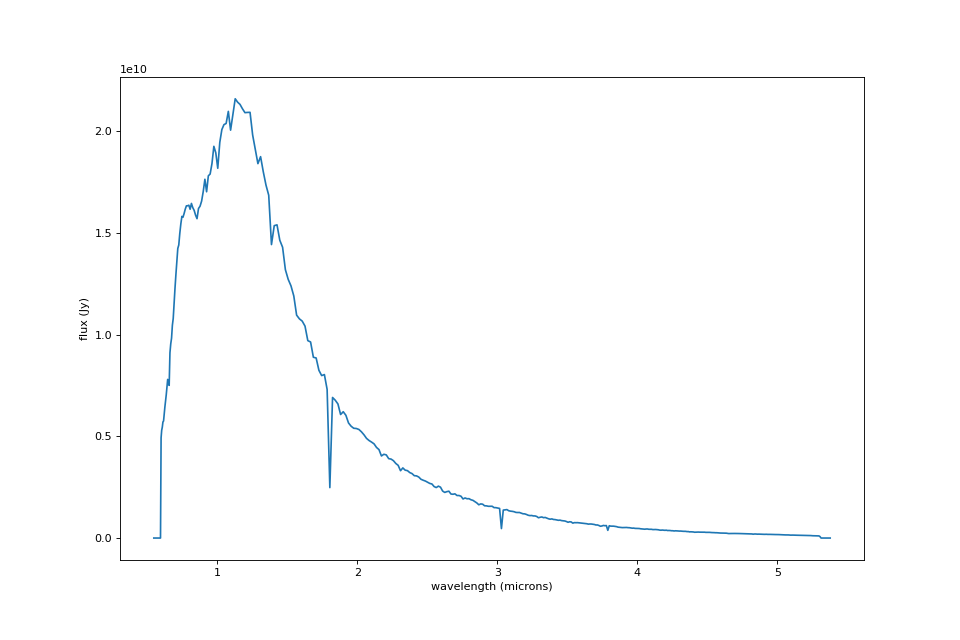

./nirspec_files/nirspec_fssim_d6_cal.fits
S200A1


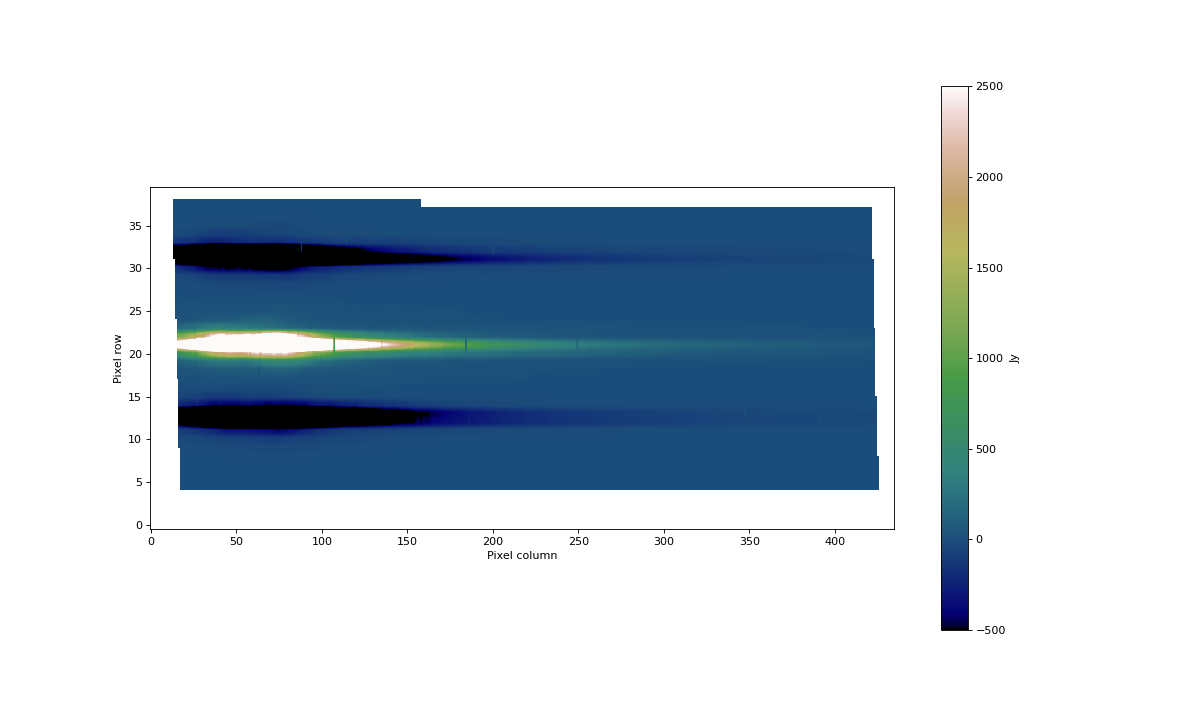

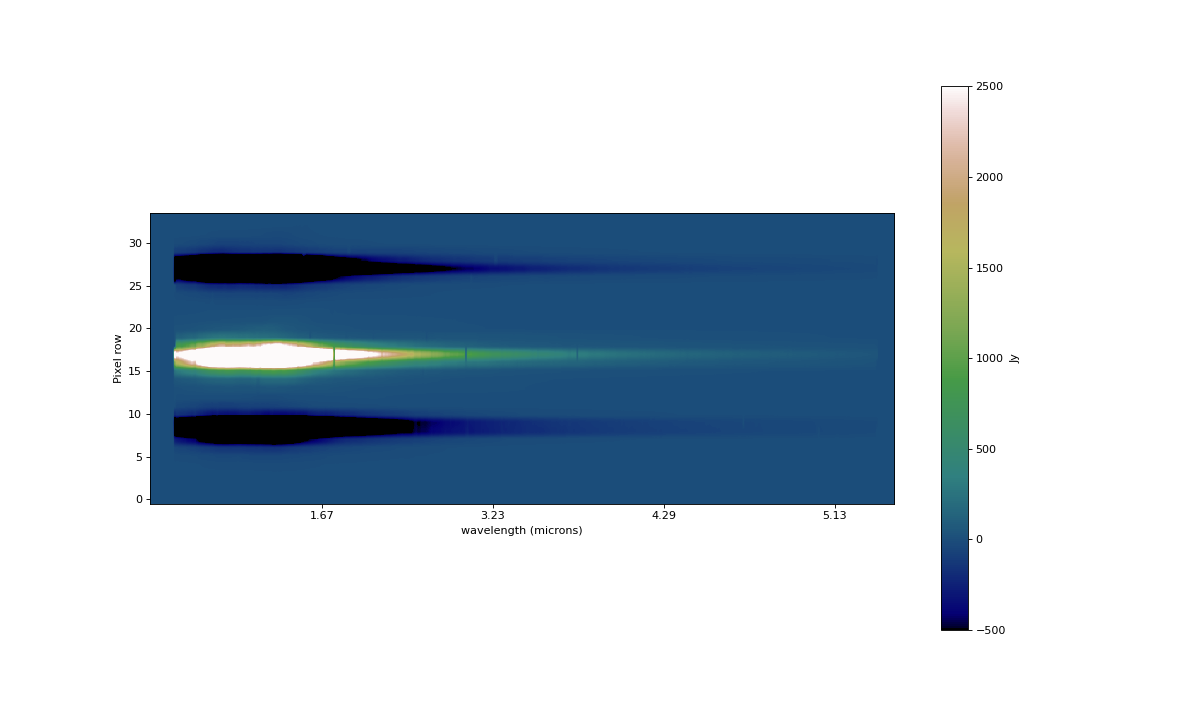

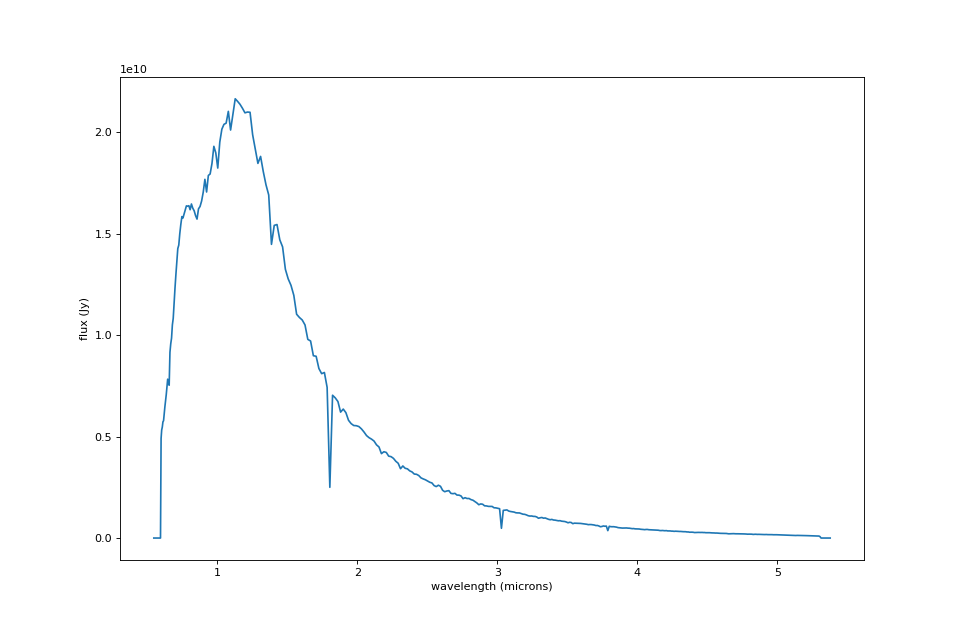

./nirspec_files/nirspec_fssim_d7_cal.fits
S200A1


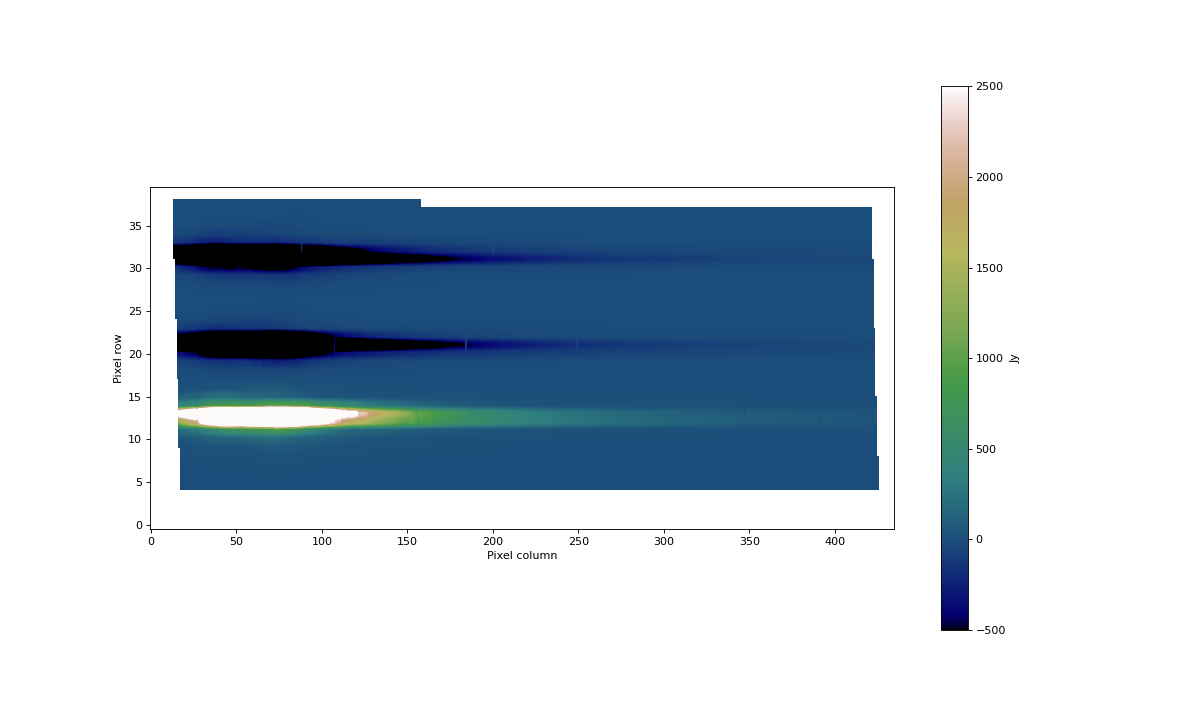

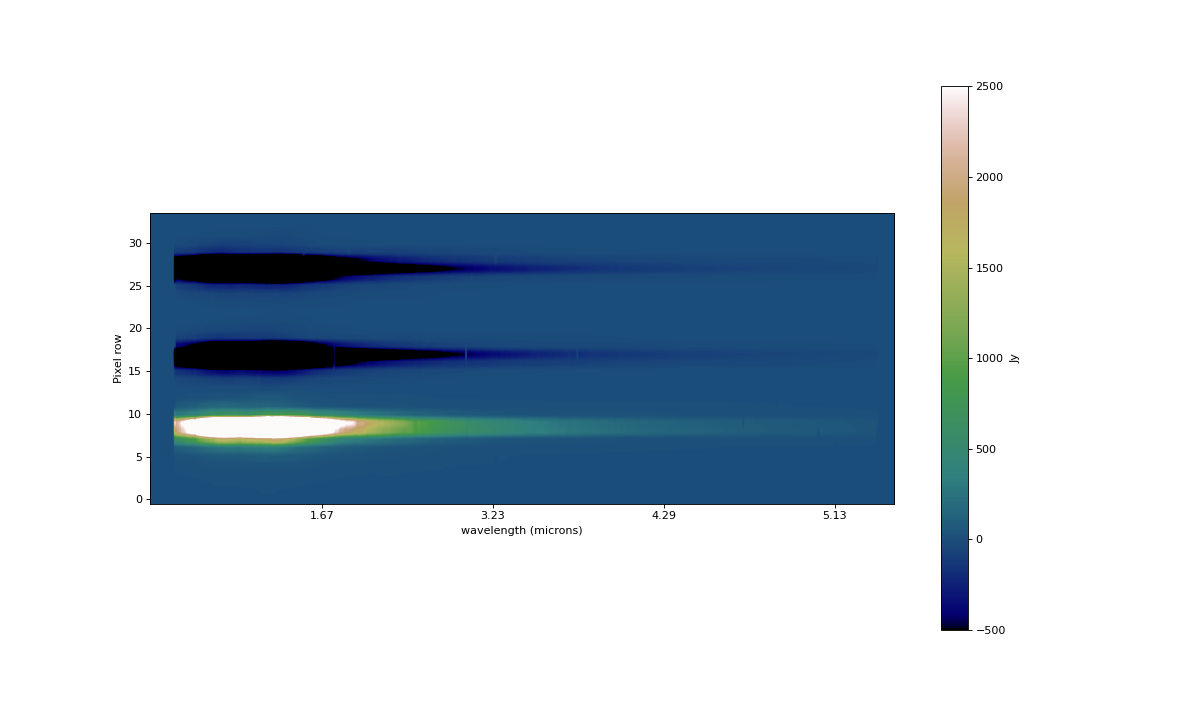

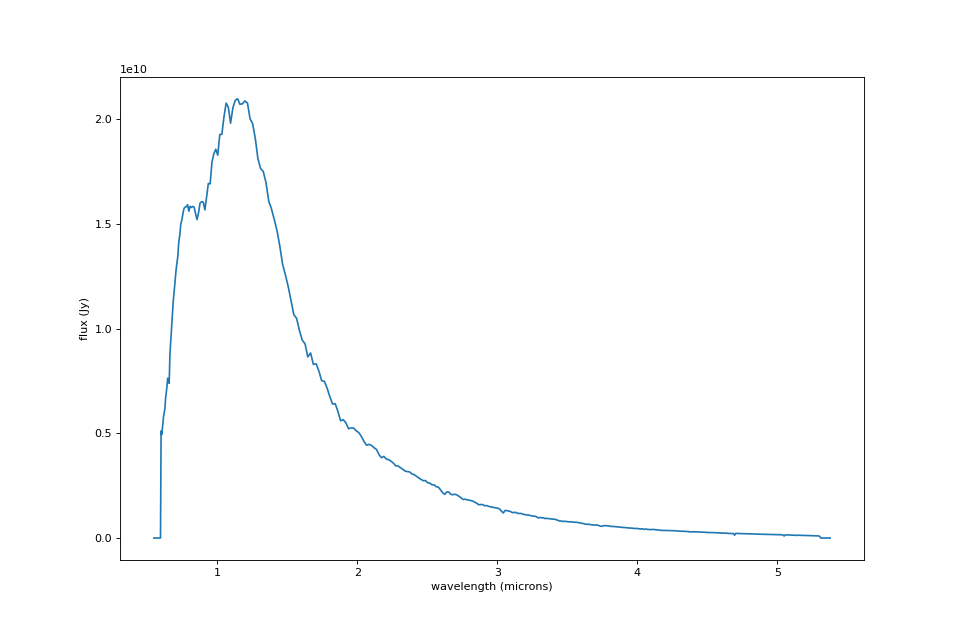

./nirspec_files/nirspec_fssim_d8_cal.fits
S200A1


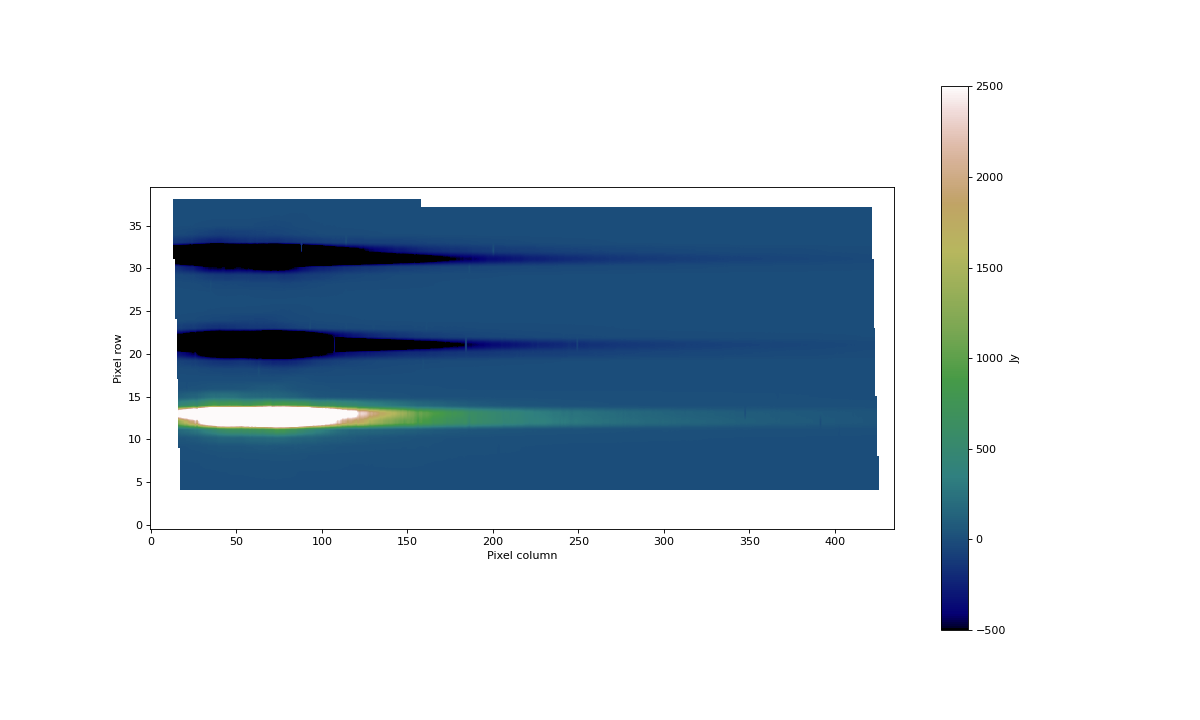

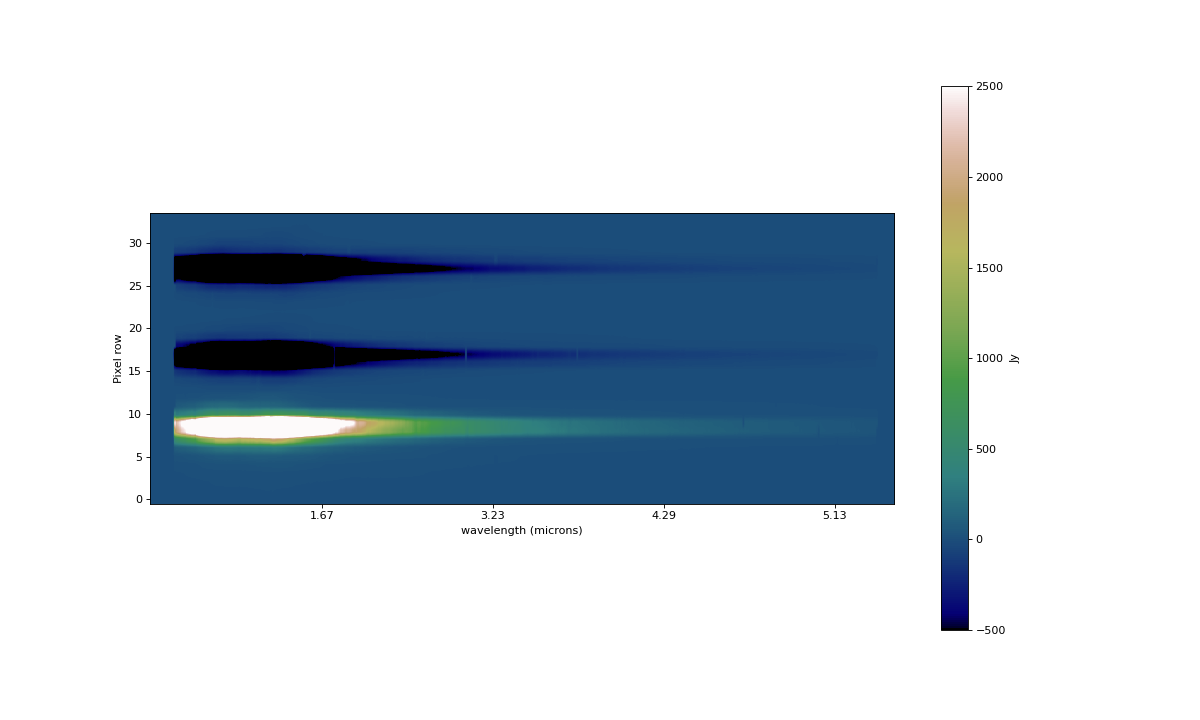

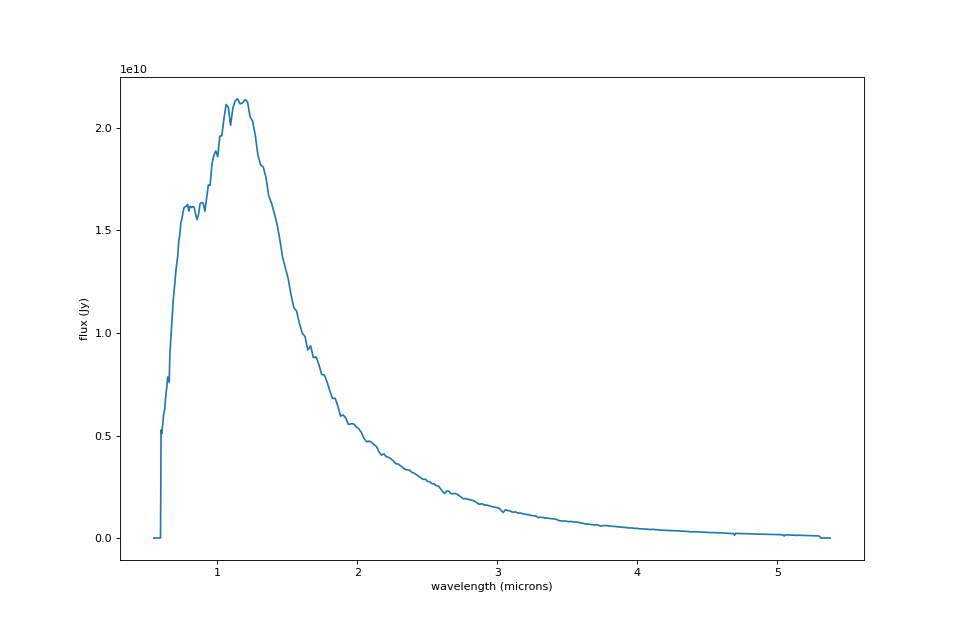

./nirspec_files/nirspec_fssim_d9_cal.fits
S200A1


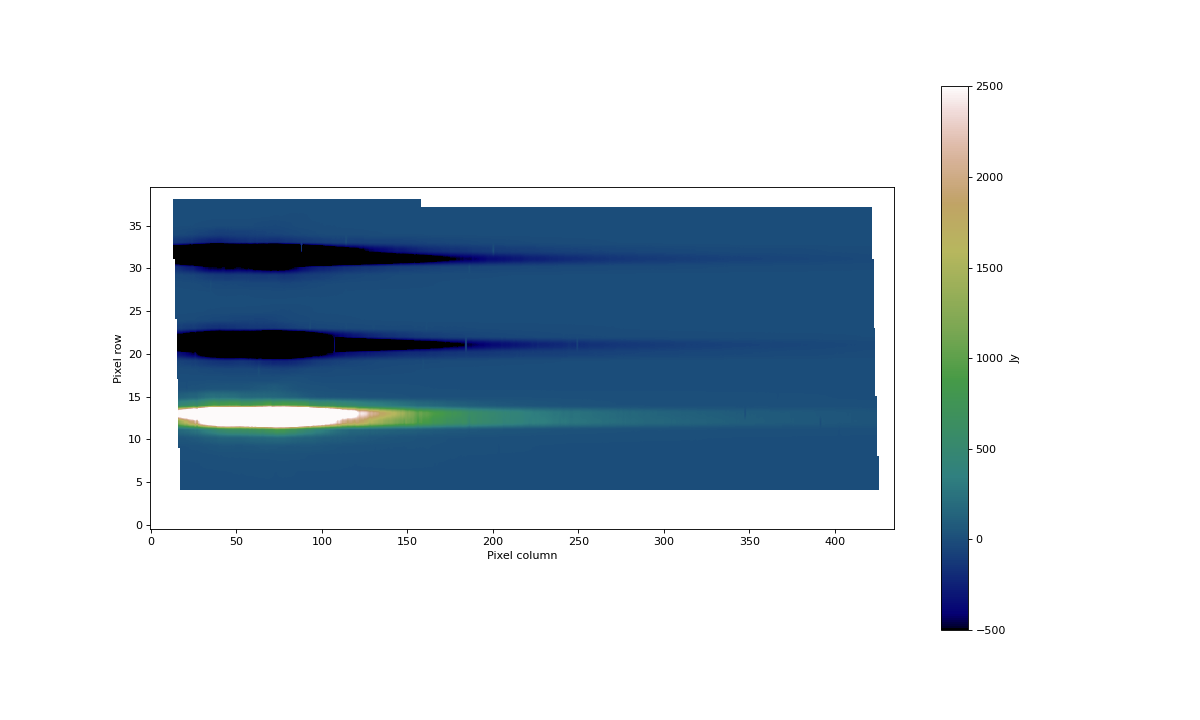

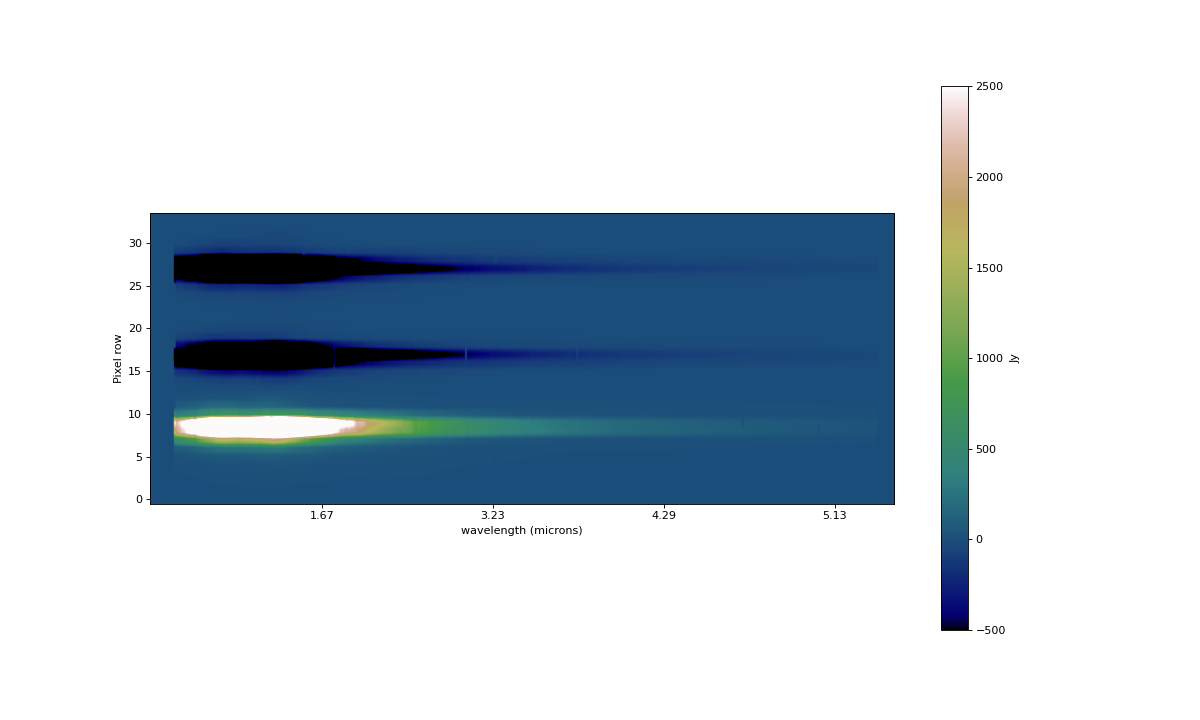

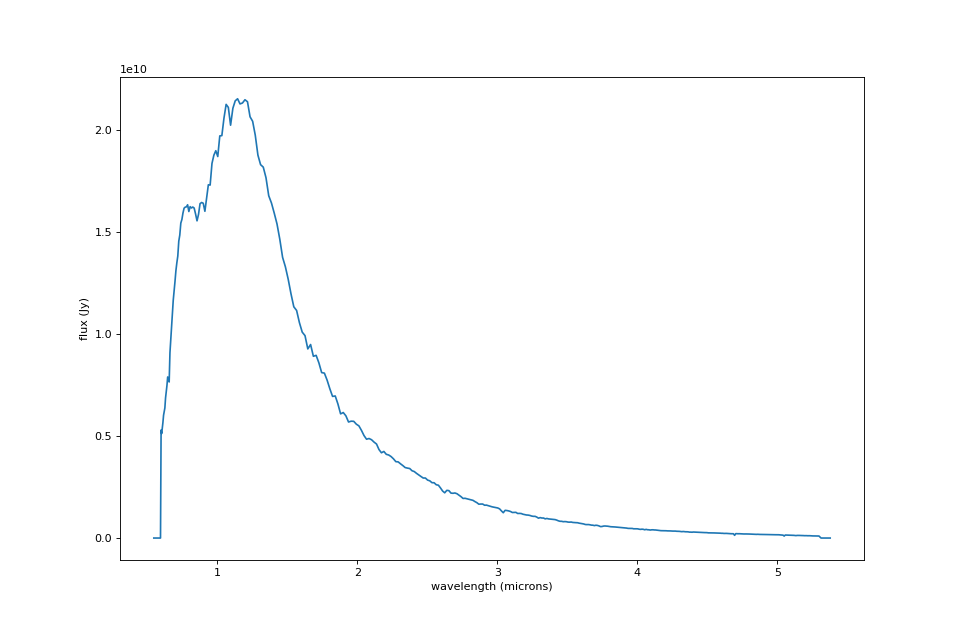

./nirspec_files/nirspec_fssim_s00001_nirspec_clear-prism-s200a1-subs200a1_cal.fits


In [20]:
# take a look at the results - open the level 2b files

callist = [f for f in glob.glob(output_dir+"*cal.fits")]
callist.sort()
for calfile in callist:
    print(calfile)
    cal = datamodels.open(calfile) # this contains the calibrated unrectified 2D spectrum
    root = calfile[:-9]
    s2d = datamodels.open(root+'_s2d.fits')  # this contains the calibrated *rectified* 2D spectrum
    x1d = datamodels.open(root+'_x1d.fits')  # this contains the aperture-extracted 1D spectrum
    
    for slit in cal.slits:
        # this data model is set up to handle multiple slits, which is mainly needed for MOS and WFSS data
        # in this case, there is only one slit, S200A1
        print(slit.name)
        
        calsci = slit.data  # contains the pixel data from the cal file (SCI extension)
        s2dsci = s2d.slits[0].data  # contains the pixel data from the s2d file
    
        # determine the wavelength scale of the s2d data for plotting purposes
        # get the data model WCS object
        wcsobj = s2d.slits[0].meta.wcs
        y, x = np.mgrid[:s2dsci.shape[0], : s2dsci.shape[1]]  # grid of pixel x,y indices
        det2sky = wcsobj.get_transform('detector', 'world')  # the coordinate transform from detector space (pixels) to sky (RA, DEC in degrees)
        ra, dec, s2dwave = det2sky(x, y)  # RA, Dec, wavelength (microns) for each pixel
        s2dwaves = s2dwave[0, :]  # only need a single row of values since this is the rectified spectrum
        xtint = np.arange(100, s2dsci.shape[1], 100)
        xtlab = np.round(s2dwaves[xtint], 2)  # wavelength labels for the x-axis
        
        # get wavelength & flux from the x1d data model
        x1dwave = x1d.spec[0].spec_table.WAVELENGTH
        x1dflux = x1d.spec[0].spec_table.FLUX
        
        show_image(calsci, -5.e2, 2.5e3, aspect=5., scale='linear', units='Jy')
        
        show_image(s2dsci, -5.e2, 2.5e3, aspect=5., scale='linear', units='Jy')
        plt.xticks(xtint, xtlab)
        plt.xlabel('wavelength (microns)')
        
        fig = plt.figure(figsize=(12, 8))
        plt.plot(x1dwave, x1dflux)
        plt.xlabel('wavelength (microns)')
        plt.ylabel('flux (Jy)')
        plt.show()

## Run individual steps of the spec2 pipeline <a id='runspec2steps'></a>

Now let's try running individual pipeline steps on a single exposure, and taking a look at their output to give a flavor for what they are doing to the data.

### assign_wcs <a id='awcs'></a>

This is a complex step that generates tranfsorms between various instrument optical planes and the sky, using the NIRSpec instrument model with multiple reference files.

In [21]:
filename = output_dir+'nirspec_fssim_d5_rate.fits'  # an input level 2a file
root = filename[:-9]  # for later matching
print(root)

step = AssignWcsStep()
step.save_results = True
step.output_dir = output_dir
result = step(filename)

./nirspec_files/nirspec_fssim_d5_


Note the verbose output prints the values of various instrument parameters that are relevant for the construction of the instrument transforms, such as the grating wheel tilt and the slit (or slits, in the case of MOS) used for the exposure.  In this demo, a fixed slit was used, which is indicated here by "quadrant 5"; if this had been a MOS exposure, there would be multiple slits indicated in any or all of quadrants 1-4.

In [22]:
# The output file has the suffix _assignwcsstep appended:
awcs_output_file = root+'assignwcsstep.fits'
print(awcs_output_file)

# load the output into a data model container
awcs = datamodels.open(awcs_output_file)
awcs

./nirspec_files/nirspec_fssim_d5_assignwcsstep.fits


<ImageModel(64, 2048) from nirspec_fssim_d5_assignwcsstep.fits>

The actual pixel data are not changed as a result of this step.  Instead, a WCS object is created in the asdf extension of the output file that includes all the various optical transforms and component descriptions encompassed by the instrument model.

In [23]:
# get the WCS information populated by the algorithms of the assign_wcs step
wcsobj = awcs.meta.wcs

In [24]:
# list the frames of reference available for transformation
wcsobj.available_frames

['detector',
 'sca',
 'gwa',
 'slit_frame',
 'msa_frame',
 'oteip',
 'v2v3',
 'v2v3vacorr',
 'world']

In [25]:
# examples of the units for some of these frames
print(wcsobj.detector.unit) # xy pixel indices
print(wcsobj.slit_frame.unit)  # relative xy position in the slit aperture
print(wcsobj.msa_frame.unit)  # absolute xy position in the slit aperture
print(wcsobj.world.unit)  # RA, Dec sky position

(Unit("pix"), Unit("pix"))
(Unit(dimensionless), Unit(dimensionless), Unit("um"))
(Unit("m"), Unit("m"), Unit("um"))
(Unit("deg"), Unit("deg"), Unit("um"))


These correspond to image and pupil planes in the instrument, including the detector, the grating wheel, the slit aperture, and various sky planes.  One can transform between any two of these using the appropriate transformation. We'll see an example of such a transform below, after running the extract_2d step.

### background <a id='background'></a>

If there are associated exposures to be used as backgrounds (as in a nod set), this step will average them (if more than one), and then directly subtract from the exposure being processed.

In [27]:
filename = root+'assignwcsstep.fits'  # the output from the previous step

backgrounds = [output_dir+'nirspec_fssim_d2_rate.fits', output_dir+'nirspec_fssim_d8_rate.fits']
# these exposures are for the middle spectral dither positions at primary dither positions 1 and 3

step = BackgroundStep()
step.save_results = True
step.output_dir = output_dir
result = step(filename, backgrounds)

Look at the output.  Since this step does a direct image-to-image subtraction, and the input backgrounds were the "top" and "bottom" primary dither positions, we should see a positive source trace surrounded by negative traces on either side.

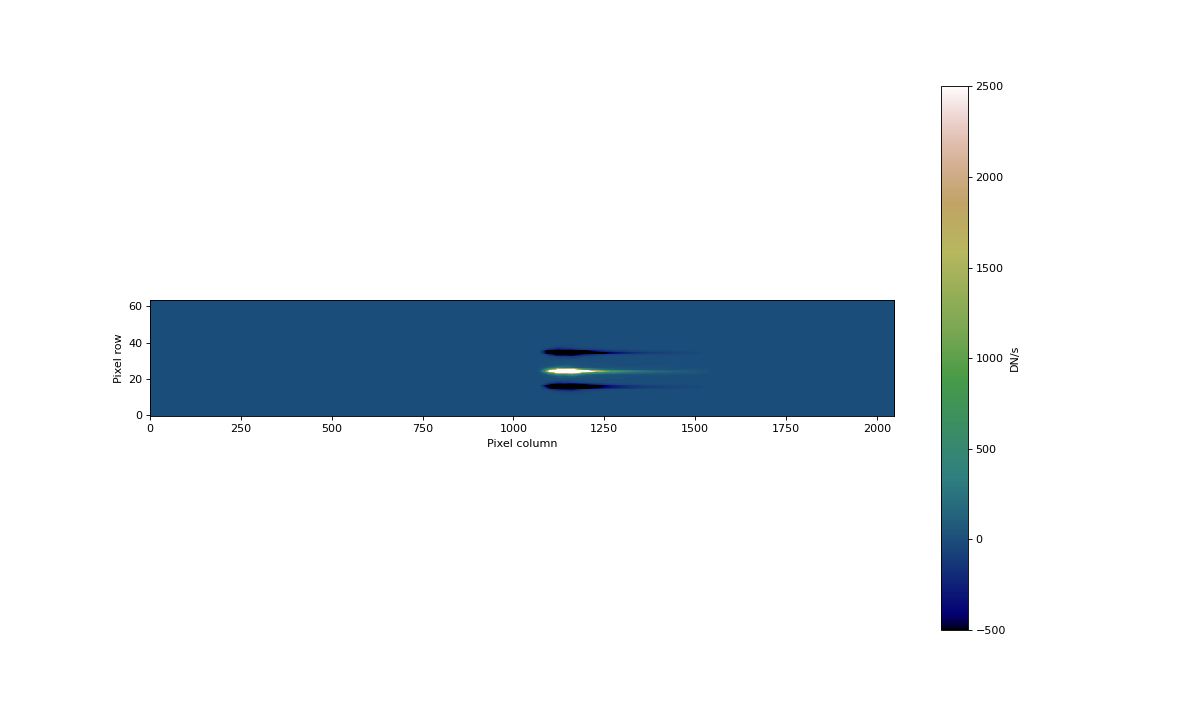

In [29]:
# The output file has the suffix _backgroundstep appended:
bsubfile = root+'backgroundstep.fits'

# load the output into a data model container
bsub = datamodels.open(bsubfile)

# plot the image
show_image(bsub.data, -5.e2, 25.e2, aspect=5., scale='linear', units='DN/s')

### extract_2d <a id='extract2d'></a>

Using the WCS transforms constructed by assign_wcs, this step extracts a 2D "subwindow" from the original full frame or (in this case) subarray image.  For MOS data, there are multiple 2D extractions corresponding to the multiple sources observed in the exposure.

In [30]:
filename = root+'backgroundstep.fits'  # the output from the previous step

step = Extract2dStep()
step.save_results = True
step.output_dir = output_dir
result = step(filename)

The bounds of the 2D extraction are printed in the above verbose output as "Subarray x/y-extents".  They are determined based on the expected wavelength and slit projection limits appropriate for the aperture and grating/filter combination being used.

./nirspec_files/nirspec_fssim_d5_extract2dstep.fits


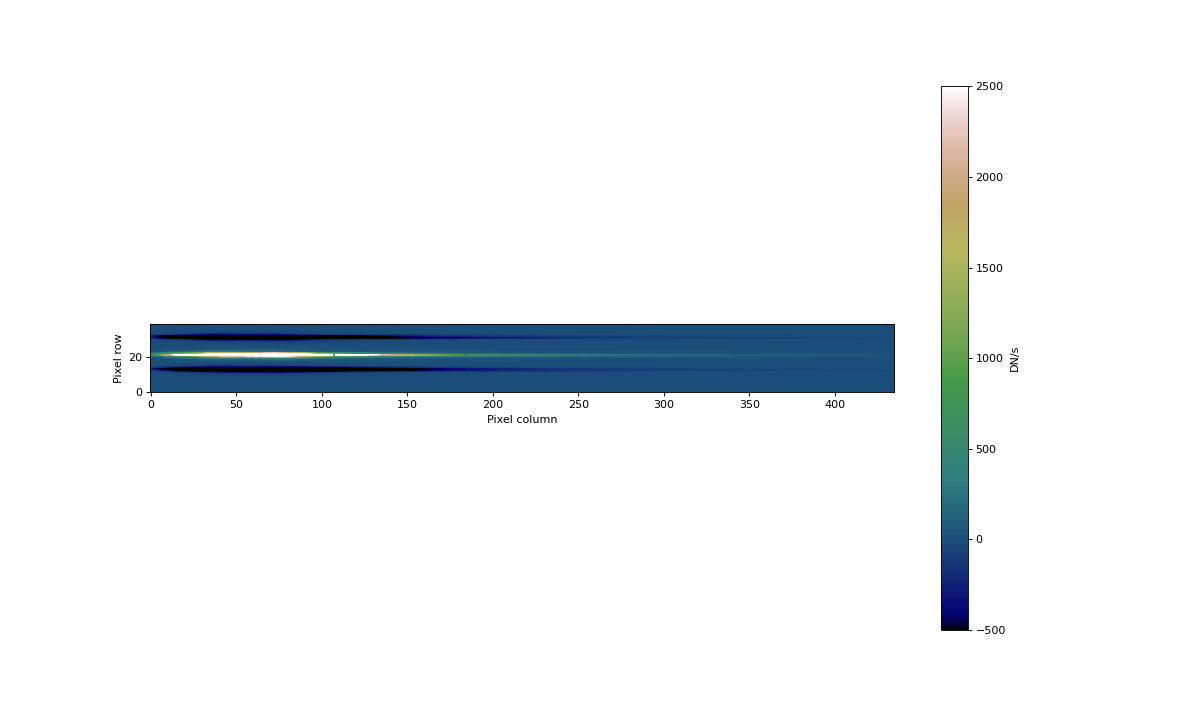

In [31]:
# The output file has the suffix _extract2dstep appended:
e2d_output_file = root+'extract2dstep.fits'
print(e2d_output_file)

# load the output into a data model container
e2d = datamodels.open(e2d_output_file)

# plot the image
show_image(e2d.slits[0].data, -5.e2, 25.e2, aspect=1., scale='linear', units='DN/s')

Now let's use the WCS object to find the source trace in sky coordinates.  This involves some of the transformations that were set up in the assign_wcs step.  Various WCS parameters can be calculated per pixel, including wavelength, sky coordinates, and internal instrument optical plane coordinates.

2021-06-15 12:57:24,366 - stpipe - WARNING - /Users/muzerol/anaconda3/envs/jwst_1.1/lib/python3.9/site-packages/gwcs/geometry.py:203: RuntimeWarning: invalid value encountered in remainder
  lon = np.mod(lon, 360.0 * u.deg if nquant else 360.0)



catalog RA,DEC: 90.75416666666666 -70.77527777777777


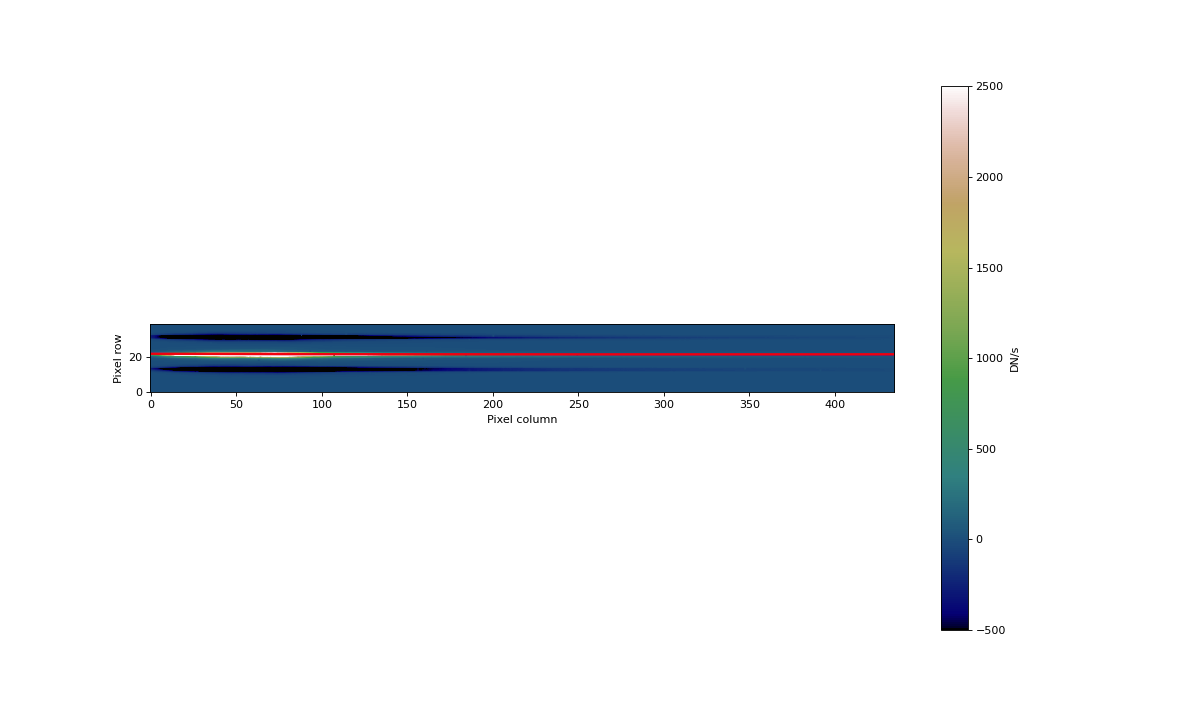

In [33]:
# get the WCS object
wcsobj = e2d.slits[0].meta.wcs

# using coordinate transforms embedded in the WCS object,
# we can calculate wavelength and sky coordinates for each pixel in the 2D spectrum
y, x = np.mgrid[:e2d.slits[0].data.shape[0], : e2d.slits[0].data.shape[1]]
det2sky = wcsobj.get_transform('detector', 'world')  # this is the transform from detector space (pixel coordinates) to the sky (RA, Dec in degrees)
calra, caldec, calwave = det2sky(x, y)
calwaves = calwave[0, :] # get the set of wavelength values for the first pixel row, for later use

# get the source RA and Dec coordinates from the metadata (also located in the header of the fits SCI extension)
source_ra = e2d.slits[0].meta.target.ra
source_dec = e2d.slits[0].meta.target.dec
print('catalog RA,DEC:', source_ra, source_dec)
        
# find the trace of the source coordinates
calxm = np.arange(calra.shape[1])
calym = np.arange(calra.shape[0])
calym_ra = np.zeros(calra.shape[1])
calym_dec = np.zeros(calra.shape[1])
for j in range(len(calxm)):
    col = calra[:, j]
    calym_ra[j] = np.interp(source_ra, col[np.isfinite(col)], calym[np.isfinite(col)])
    col = caldec[:, j]
    calym_dec[j] = np.interp(source_dec, col[np.isfinite(col)], calym[np.isfinite(col)])
    
# plot
show_image(e2d.slits[0].data, -5.e2, 25.e2, aspect=1., scale='linear', units='DN/s')
plt.plot(calxm, calym_ra, color='purple', alpha=0.9, linewidth=2)
plt.plot(calxm, calym_dec, color='red', alpha=0.9, linewidth=2)

### sourcetype <a id='srctype'></a>

This step sets the source type (point or extended) based on information passed from PPS (given in the SRCTYAPT header keyword); if no flag was set, by default the type is set to point.  This affects subsequent processing steps, which do different things for each type.

In [34]:
filename = root+'extract2dstep.fits'  # the output from the previous step

step = SourceTypeStep()
step.save_results = True
step.output_dir = output_dir
result = step(filename)

keyword SRCTYPE should be set to "POINT" in this case, because PPS database value SRCTYAPT is "UNKNOWN"

In [35]:
# The output file has the suffix _sourcetypestep appended:
stype_output_file = root+'sourcetypestep.fits'

# load the output into a data model container
stype = datamodels.open(stype_output_file)

# what is the SRCTYPE keyword value?
stype.find_fits_keyword('SRCTYPE')
print('SRCTYPE=', stype.meta.target.source_type)

SRCTYPE= POINT


### wavecorr <a id='wavecorr'></a>

The wavelength values per pixel need to be corrected when a point source is not located at the center of a slit aperture in the dispersion direction.  (Due to a bug in how the source slit position is currently being calculated, the correction is effectively zero for FS data regardless of the dither position.)

In [36]:
filename = root+'sourcetypestep.fits'  # the output from the previous step

step = WavecorrStep()
step.save_results = True
step.output_dir = output_dir
result = step(filename)

In [37]:
# The output file has the suffix _wavecorrstep appended:
wavecor_output_file = root+'wavecorrstep.fits'

# load the output into a data model container
wavecor = datamodels.open(wavecor_output_file)

### flat_field <a id='flat'></a>

A flat field correction is applied to each pixel in the 2D spectrum.  The NIRSpec "flat" comprises three components: D flat, which includes the pixel-to-pixel detector response; S flat, which includes the throughput of the spectrograph; F flat, which folds together the throughput of the filter, FORE optics, and OTE.

In [38]:
filename = root+'wavecorrstep.fits'  # the output from the previous step

step = FlatFieldStep()
step.save_interpolated_flat = True  # this will save the on-the-fly flat field correction values as an image
step.save_results = True
step.output_dir = output_dir
result = step(filename)

In [39]:
# The output file has the suffix _flatfieldstep appended:
flat_output_file = root+'flatfieldstep.fits'

# The optional saved flat correction image has the suffix _interpolatedflat appended:
intflat_output_file = root+'interpolatedflat.fits'

# load the output into a data model container
flat = datamodels.open(flat_output_file)
intflat = datamodels.open(intflat_output_file)

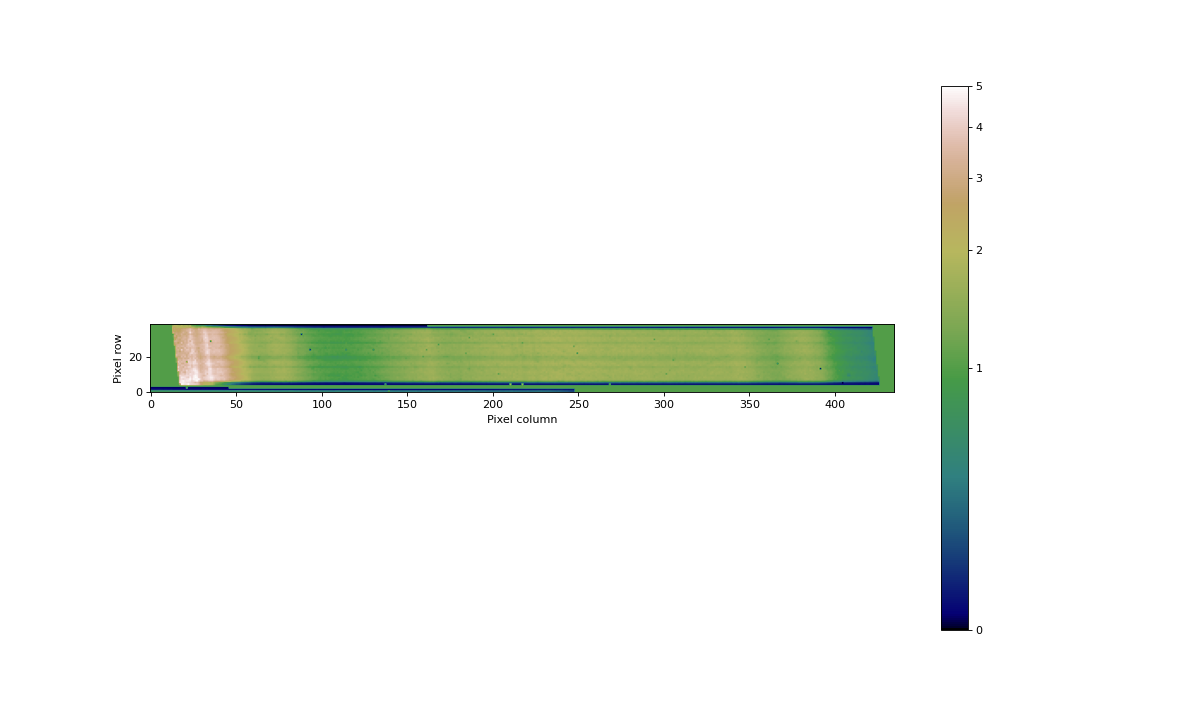

In [40]:
# plot the flat correction image - this is divided into the science exposure to apply the corrections per pixel
show_image(intflat.slits[0].data, 0., 5., aspect=1., scale='Asinh', units='')

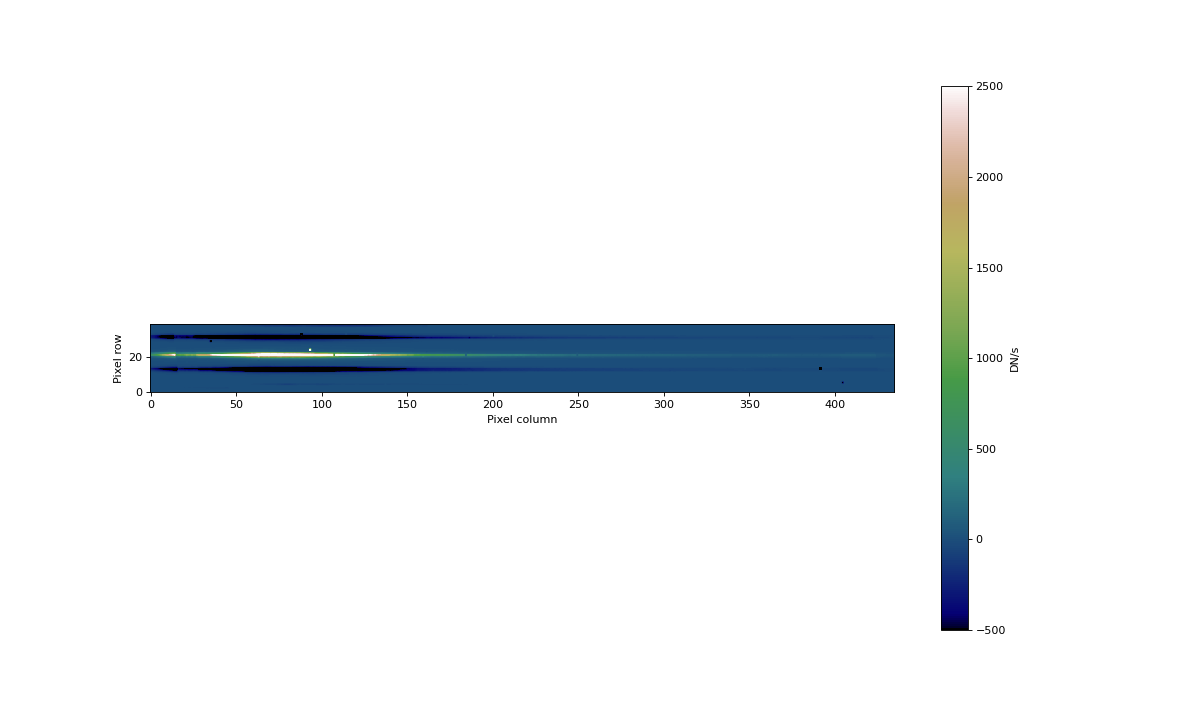

In [41]:
# plot the corrected science exposure
# note the simulation does not include all of the flat components, so applying the full correction in this case produces incorrect results
show_image(flat.slits[0].data, -5.e2, 25.e2, aspect=1., scale='linear', units='DN/s')

### pathloss <a id='pathloss'></a>

The pathloss correction scales the 2D spectrum as a function of wavelength to account for geometric and diffraction losses of a non-centered point source incurred by the slit aperture.  This is only relative to a centered source, as the absolute pathloss in that case has already been corrected by the F flat component of the flat field correction. (Due to the aforementioned bug in how the source slit position is currently being calculated, this correction is effectively one for FS data regardless of the dither position.)

In [42]:
filename = root+'flatfieldstep.fits'  # the output from the previous step

step = PathLossStep()
step.save_results = True
step.output_dir = output_dir
result = step(filename)

In [43]:
# The output file has the suffix _pathlossstep appended:
ploss_output_file = root+'pathlossstep.fits'

# load the output into a data model container
ploss = datamodels.open(ploss_output_file)

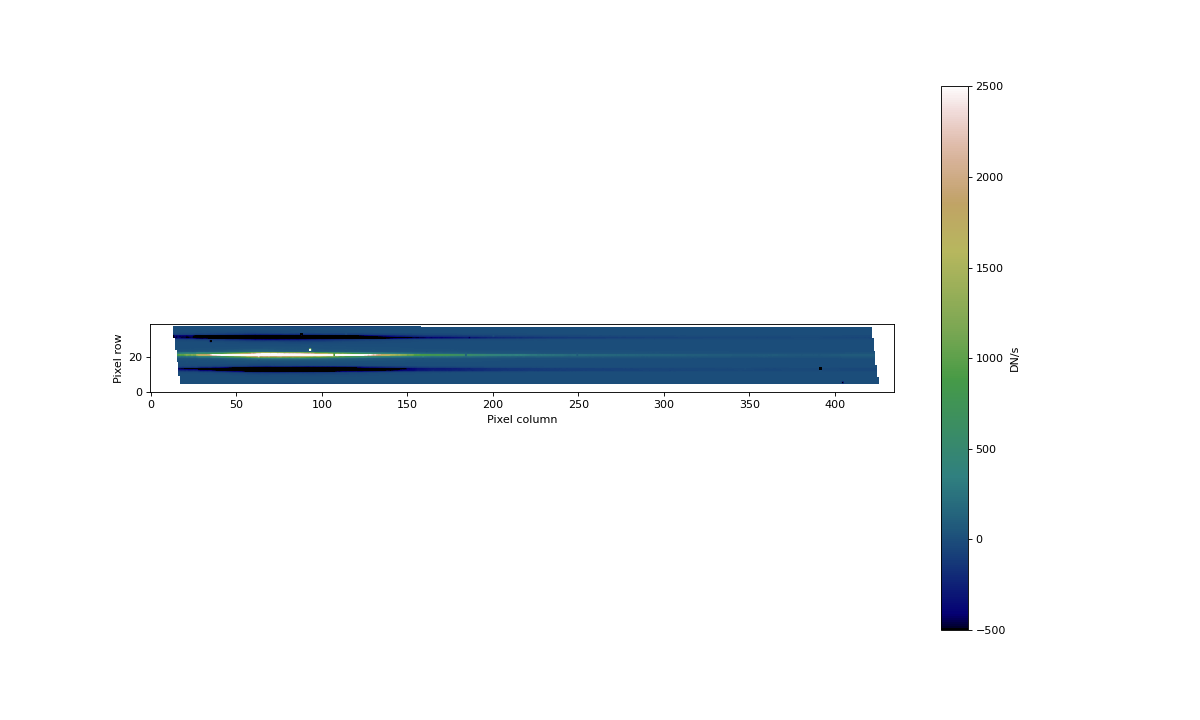

In [44]:
# plot the corrected science exposure
show_image(ploss.slits[0].data, -5.e2, 25.e2, aspect=1., scale='linear', units='DN/s')

### photom <a id='photom'></a>

The photom step applies a scalar conversion factor to convert to physical units.  Once on-orbit observations of spectrophotometric standards are obtained, this may also include a wavelength-dependent vector, if necessary, to account for any small discrepancies found in the throughput corrections.

In [45]:
filename = root+'pathlossstep.fits'  # the output from the previous step

step = PhotomStep()
step.save_results = True
step.output_dir = output_dir
result = step(filename)

In [46]:
# The output file has the suffix _photomstep appended:
phot_output_file = root+'photomstep.fits'

# load the output into a data model container
phot = datamodels.open(phot_output_file)

In [47]:
# what are the flux calibration-related keywords?
phot.find_fits_keyword('PHOTUJA2')
print('PHOTMJSR=', phot.slits[0].meta.photometry.conversion_megajanskys)
# note that despite the keyword name, when SRCTYPE=POINT, the units are actually MJy per pixel
# the pre-launch reference file has a placeholder value, so the output fluxes will appear unphysically large
print('PHOTUJA2=', phot.slits[0].meta.photometry.conversion_microjanskys)
# this is only applicable for extended sources

PHOTMJSR= 1.0
PHOTUJA2= 23.50443053909789


### resample_spec <a id='resample'></a>

The fully calibrated 2D spectrum is resampled onto a rectified grid in sky and wavelength coordinates. This is intended for quick-look purposes only, as all of the calibrated unrectified exposures will be resampled and combined onto a common grid during the level 3 processing.

In [48]:
filename = root+'photomstep.fits'  # the output from the previous step

step = ResampleSpecStep()
step.save_results = True
step.output_dir = output_dir
result = step(filename)

In [49]:
# The output file has the suffix _resamplespecstep appended:
s2d_output_file = root+'resamplespecstep.fits'

# load the output into a data model container
s2d = datamodels.open(s2d_output_file)

2021-06-15 13:03:20,205 - stpipe - WARNING - /Users/muzerol/anaconda3/envs/jwst_1.1/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



2021-06-15 13:03:29,715 - stpipe - WARNING - /Users/muzerol/anaconda3/envs/jwst_1.1/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



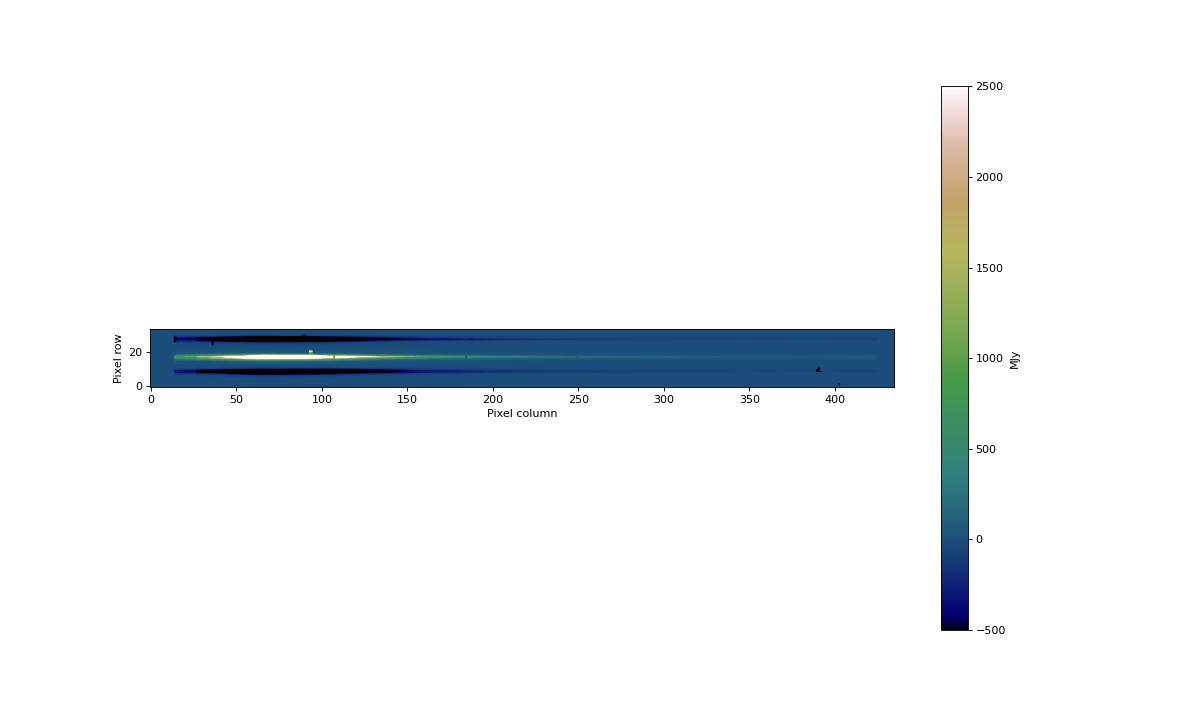

In [50]:
# plot the rectified 2D spectrum
show_image(s2d.slits[0].data, -5.e2, 25.e2, aspect=1., scale='linear', units='MJy')

### extract_1d <a id='extract1d'></a>

A 1D spectrum is extracted from the resampled 2D product, using an aperture size specified from a reference file.  An aperture correction is also applied to account for flux outside of the extraction aperture. As with the resample_spec level 2b product, this is intended for quick-look purposes only.  An independent extraction of the combined rectified 2D spectrum will be done during level 3 processing.

In [51]:
filename = root+'resamplespecstep.fits'  # the output from the previous step

step = Extract1dStep()
step.save_results = True
step.output_dir = output_dir
result = step(filename)

In [52]:
# The output file has the suffix _extract1dstep appended:
x1d_output_file = root+'extract1dstep.fits'

# load the output into a data model container
x1d = datamodels.open(x1d_output_file)

2021-06-15 13:03:44,037 - stpipe - WARNING - /Users/muzerol/anaconda3/envs/jwst_1.1/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



2021-06-15 13:03:50,223 - stpipe - WARNING - /Users/muzerol/anaconda3/envs/jwst_1.1/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



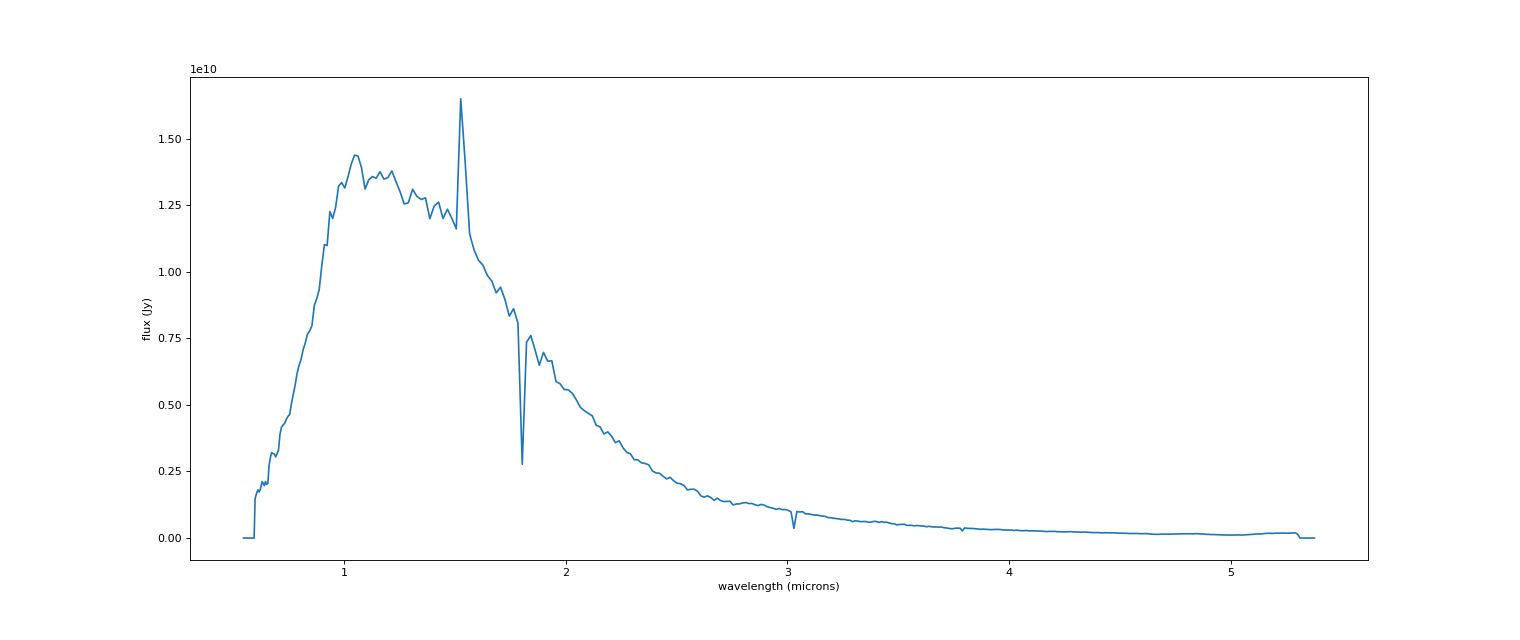

In [53]:
# plot the spectrum
x1dwave = x1d.spec[0].spec_table.WAVELENGTH
x1dflux = x1d.spec[0].spec_table.FLUX

fig = plt.figure(figsize=(19, 8))
plt.plot(x1dwave, x1dflux)
plt.xlabel('wavelength (microns)')
plt.ylabel('flux (Jy)')
plt.show()

# note that the flux level appears artificially inflated because of the dummy flux conversion factor applied in the photom step

## Run the calwebb_spec3 pipeline <a id='runspec3'></a>

For an observation that contains multiple exposures of the same source, such as the nod set in this example, this pipeline will combine all of the exposures into a single output product.  Both a rectified 2D and extracted 1D spectrum are generated.  The pipeline includes includes an outlier detection step that compares the stack of values at each resampled pixel and flags outliers based on noise threshold parameters; the flagged outliers are not included in the spectral combination. However, we will skip this step because the simulations are noiseless, which would result in spurious results.  We will also not demonstrate the optional "master background" step, which takes an independent 1D background spectrum to create a 2D background to subtract in the absence of nodded exposures; see the read-the-docs pages for more details.

In [54]:
# run the calwebb_spec3 pipeline using association file of cal.fits files

# get the association file
asn = output_dir+"spec3_all_asn.json"

# loop over the association files (one per exposure)
spec3 = Spec3Pipeline()
spec3.save_results = True
spec3.output_dir = output_dir
spec3.outlier_detection.skip = True  # skip this step for now, because the simulations do not include noise
result = spec3(asn)

2021-06-15 15:11:32,848 - stpipe - WARNING - /Users/muzerol/anaconda3/envs/jwst_1.1/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)

2021-06-15 15:11:42,987 - CRDS - INFO -  Fetching  /grp/crds/cache/references/jwst/jwst_nirspec_apcorr_0003.fits    8.1 M bytes  (1 / 2 files) (0 / 8.1 M bytes)
2021-06-15 15:11:43,885 - CRDS - ERROR -  Failure downloading file 'jwst_nirspec_apcorr_0003.fits' : Error fetching data for 'jwst_nirspec_apcorr_0003.fits' at CRDS server 'https://jwst-crds.stsci.edu' with mode 'http' : [Errno 13] Permission denied: '/grp/crds/cache/references/jwst/jwst_nirspec_apcorr_0003.fits'
2021-06-15 15:11:43,886 - CRDS - INFO -  Fetching  /grp/crds/cache/references/jwst/jwst_nirspec_

2021-06-15 15:12:22,843 - stpipe - WARNING - /Users/muzerol/anaconda3/envs/jwst_1.1/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Text(0.5, 0, 'wavelength (microns)')

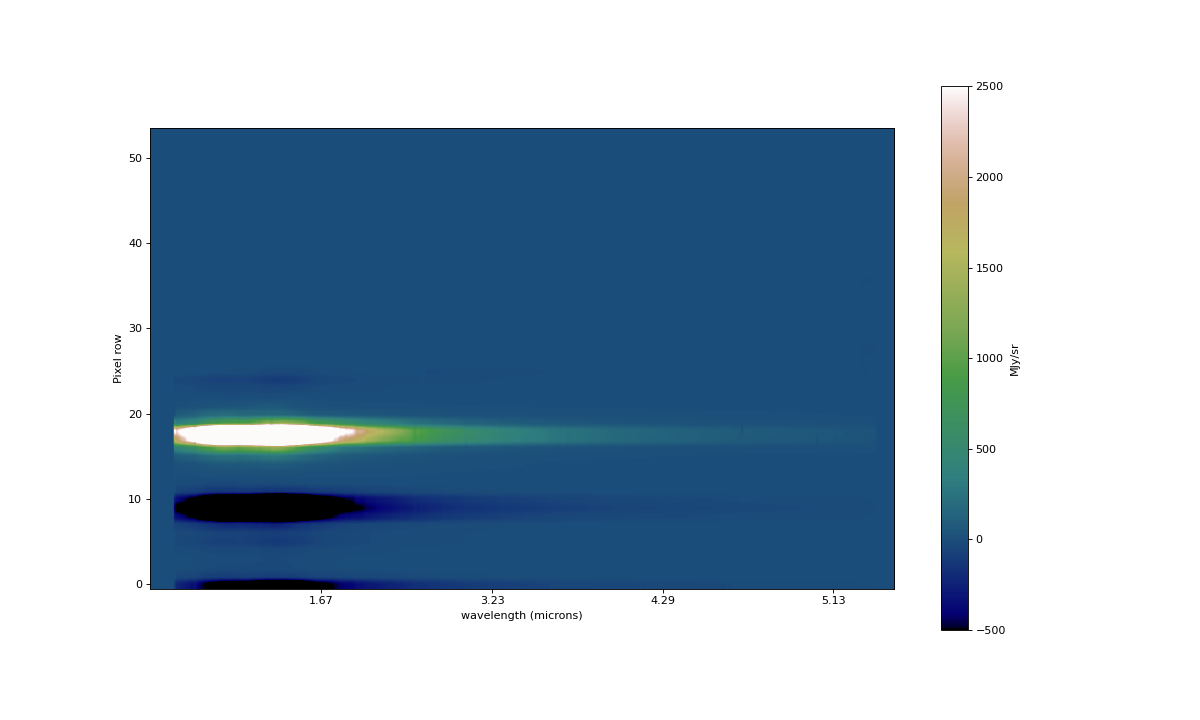

In [56]:
# display level 3 products
# combined 2D rectified spectrum
s2d3 = datamodels.open(output_dir+'nirspec_fssim_s00001_nirspec_clear-prism-s200a1-subs200a1_s2d.fits')
s2d3sci = s2d3.data

# get the wavelength scale
wcsobj = s2d3.meta.wcs
y, x = np.mgrid[:s2d3sci.shape[0], : s2d3sci.shape[1]]
det2sky = wcsobj.get_transform('detector', 'world')
s2d3ra, s2d3dec, s2d3wave = det2sky(x, y)
s2d3waves = s2d3wave[0, :]
xtint = np.arange(100, s2d3sci.shape[1], 100)
xtlab = np.round(s2d3waves[xtint], 2)

# show the combined s2d image
show_image(s2d3sci, -5.e2, 2.5e3, aspect=5., scale='linear')
plt.xticks(xtint, xtlab)
plt.xlabel('wavelength (microns)')

2021-06-15 15:12:33,733 - stpipe - WARNING - /Users/muzerol/anaconda3/envs/jwst_1.1/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



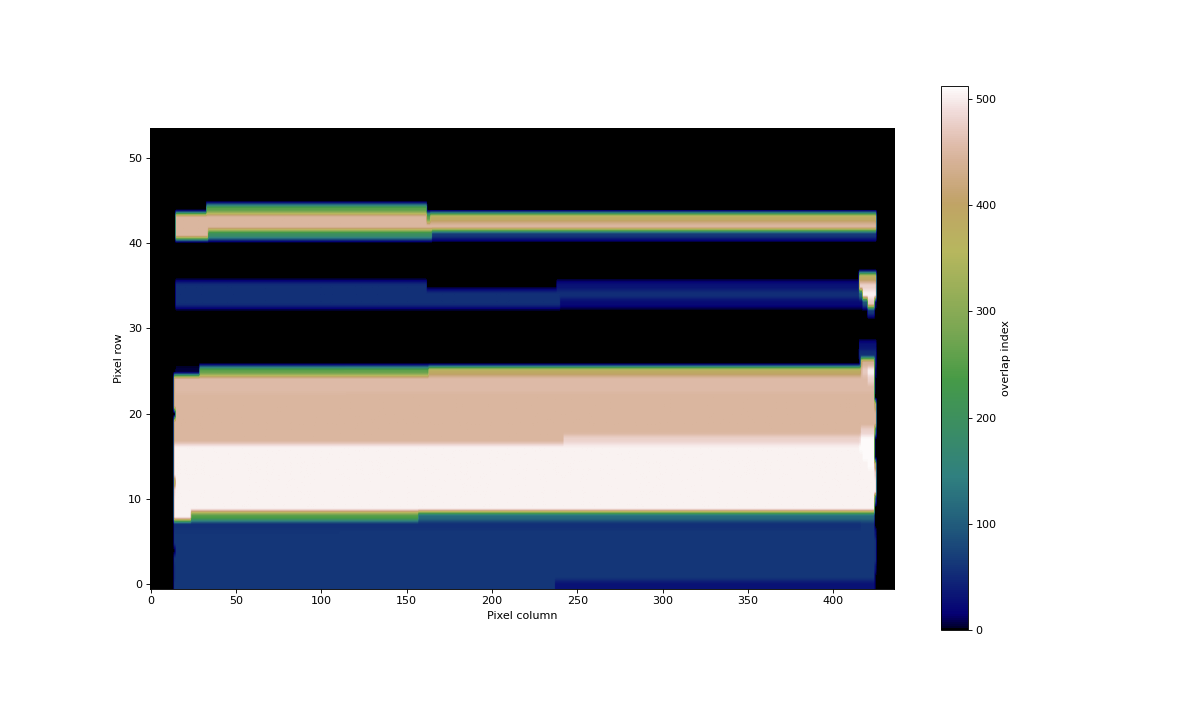

In [57]:
# show the overlap image ("CON" fits extension)
s2d3con = s2d3.con
show_image(s2d3con, 0, 512, aspect=5., scale='linear', units='overlap index')

This indicates which input exposures (identified by a binary flag) contributed to the flux in each output pixel. (Note that the values at rows >~ 27 are incorrect as a result of known a bug in this pipeline version.) 

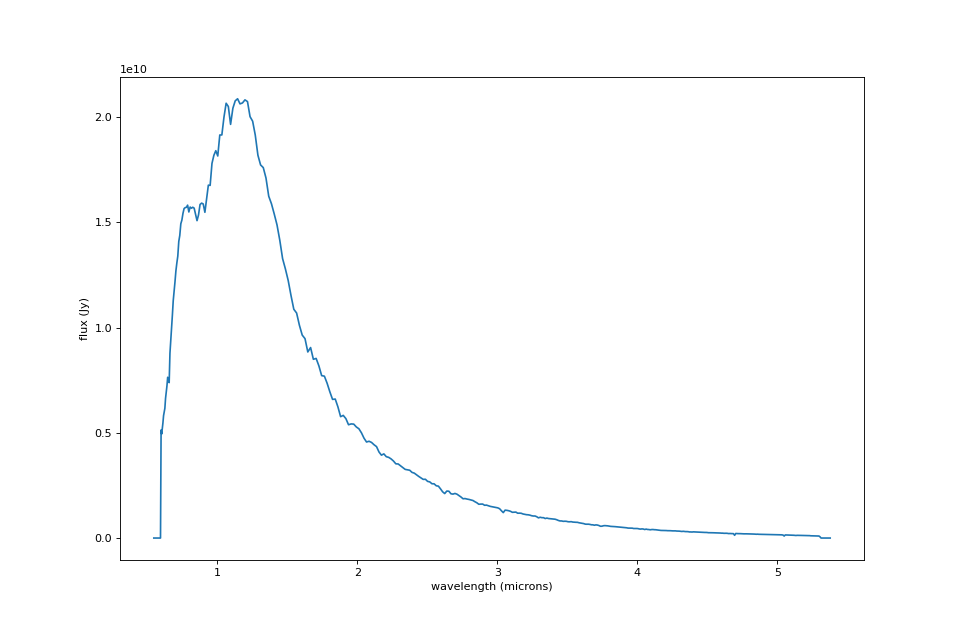

In [58]:
# combined 1D extracted spectrum
x1d3 = datamodels.open(output_dir+'nirspec_fssim_s00001_nirspec_clear-prism-s200a1-subs200a1_x1d.fits')

# get wavelength & flux
x1d3wave = x1d3.spec[0].spec_table.WAVELENGTH
x1d3flux = x1d3.spec[0].spec_table.FLUX

# plot
fig = plt.figure(figsize=(12, 8))
plt.plot(x1d3wave, x1d3flux)
plt.xlabel('wavelength (microns)')
plt.ylabel('flux (Jy)')
plt.show()

### Rerun extract_1d with a different extraction aperture <a id='rerun'></a>

In [59]:
# show the contents of the extract_1d reference file
reffile = output_dir+'jwst_nirspec_extract1d_0004.json'
with open(reffile) as f_obj:
    e1dref = json.load(f_obj)
e1dref

2021-06-15 15:12:51,205 - stpipe - WARNING - /Users/muzerol/anaconda3/envs/jwst_1.1/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



{'reftype': 'EXTRACT1D',
 'instrument': 'NIRSPEC',
 'telescope': 'JWST',
 'exp_type': 'NRS_FIXEDSLIT',
 'pedigree': 'GROUND',
 'descrip': 'NIRSpec fixed-slit extraction params for ground testing',
 'author': 'H.Bushouse',
 'history': 'Second draft 2016-Nov-11',
 'useafter': '2001-01-01T00:00:00',
 'apertures': [{'id': 'S200A1',
   'region_type': 'target',
   'bkg_order': 0,
   'dispaxis': 1,
   'extract_width': 7,
   'nod2_offset': 9,
   'nod3_offset': 9,
   'nod5_offset': 6},
  {'id': 'S200B1',
   'region_type': 'target',
   'bkg_order': 0,
   'dispaxis': 1,
   'extract_width': 7,
   'nod2_offset': 9,
   'nod3_offset': 9,
   'nod5_offset': 6},
  {'id': 'S200A2',
   'region_type': 'target',
   'bkg_order': 0,
   'dispaxis': 1,
   'extract_width': 7,
   'nod2_offset': 9,
   'nod3_offset': 9,
   'nod5_offset': 6},
  {'id': 'S400A1',
   'region_type': 'target',
   'bkg_order': 0,
   'dispaxis': 1,
   'extract_width': 7,
   'nod2_offset': 9,
   'nod3_offset': 9,
   'nod5_offset': 6},
  {'i

In [60]:
# edit the extraction aperture width
for params in e1dref['apertures']:
    if (params['id'] == 'S200A1'):
        params['extract_width'] = 3

# create new reference file
newfile = open(output_dir+'jwst_nirspec_extract1d_news200a1.json', 'w')
json.dump(e1dref, newfile)
newfile.close()

In [61]:
# rerun extract_1d step with the new reference file
root = output_dir+'nirspec_fssim_s00001_nirspec_clear-prism-s200a1-subs200a1'
filename = root+'_s2d.fits'  # the level 3 2D spectrum

step = Extract1dStep()
step.override_extract1d = output_dir+'jwst_nirspec_extract1d_news200a1.json'
step.save_results = True
step.output_dir = output_dir
result = step(filename)

In [62]:
# The output file has the suffix _extract1dstep appended:
x1d3_output_file = root+'_extract1dstep.fits'

# load the output into a data model container
x1d3new = datamodels.open(x1d3_output_file)

2021-06-15 15:12:54,080 - stpipe - WARNING - /Users/muzerol/anaconda3/envs/jwst_1.1/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



2021-06-15 15:13:07,606 - stpipe - WARNING - /Users/muzerol/anaconda3/envs/jwst_1.1/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



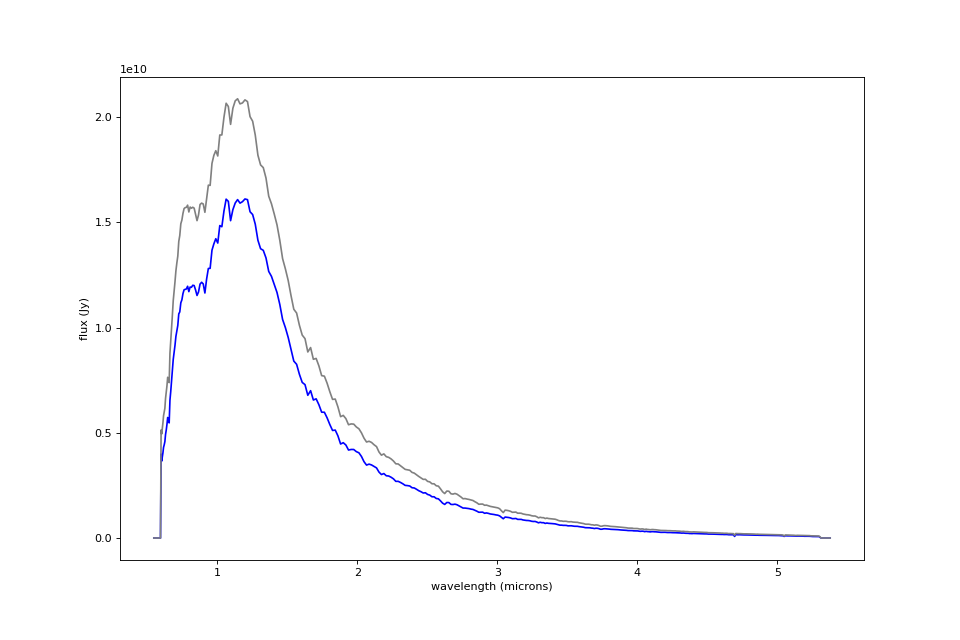

In [63]:
# get wavelength & flux
x1d3newwave = x1d3new.spec[0].spec_table.WAVELENGTH
x1d3newflux = x1d3new.spec[0].spec_table.FLUX

# plot & compare with the original version
fig = plt.figure(figsize=(12, 8))
plt.plot(x1d3newwave, x1d3newflux, color='blue')
plt.plot(x1d3wave, x1d3flux, color='gray')
plt.xlabel('wavelength (microns)')
plt.ylabel('flux (Jy)')
plt.show()

Using a narrower extraction aperture in this case results in lower flux because the default aperture correction reference file is only a placeholder. For real data obtained in flight, the two spectra should overlap, though of course the narrow-aperture version would have larger uncertainties.

<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/>